<div class="span5 alert alert-info">
<h1>Data Science Salaries (Code and supplementary graphics)</h1>
</div>

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

<div class="span5 alert alert-info">
<h2>Data taken from the 2018 Kaggle Data Science survery in this notebook is limited to those who: </h2>

<h3> (1) live in the USA, </h3>
    
<h3> (2) share their salary details, and </h3>

<h3> (3) are employed as Data Scientists </h3>

</div>

In [2]:
df = pd.read_csv("/Users/victor/Downloads/kaggle-survey-2018/multipleChoiceResponses.csv",skiprows=1)

# 1
df = df.loc[df["In which country do you currently reside?"]=="United States of America"]

# Cleaning up the labels
df = df.iloc[:,[1,3,5,6,7,9,11,12]]

df.columns = ["Gender","Age","Education","Major",
              "Occupation","Industry","Experience",
              "Salary"]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4716 entries, 0 to 23824
Data columns (total 8 columns):
Gender        4716 non-null object
Age           4716 non-null object
Education     4662 non-null object
Major         4614 non-null object
Occupation    4584 non-null object
Industry      4366 non-null object
Experience    4286 non-null object
Salary        4151 non-null object
dtypes: object(8)
memory usage: 331.6+ KB


In [3]:
# 2 and 3
df = df.dropna(subset=['Salary'])
df = df[~df.isin(['I am a student', 
                  'I do not wish to disclose my approximate yearly compensation',
                  'Student',
                  'Not employed']).any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2820 entries, 11 to 23775
Data columns (total 8 columns):
Gender        2820 non-null object
Age           2820 non-null object
Education     2820 non-null object
Major         2816 non-null object
Occupation    2820 non-null object
Industry      2820 non-null object
Experience    2819 non-null object
Salary        2820 non-null object
dtypes: object(8)
memory usage: 198.3+ KB


In [4]:
df = df[(df.Occupation=="Data Scientist")]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 11 to 23536
Data columns (total 8 columns):
Gender        777 non-null object
Age           777 non-null object
Education     777 non-null object
Major         776 non-null object
Occupation    777 non-null object
Industry      777 non-null object
Experience    777 non-null object
Salary        777 non-null object
dtypes: object(8)
memory usage: 54.6+ KB


<div class="span5 alert alert-warning">
<h2>There was 1 individual with a missing Major.</h2>

<h3> "Unknown" replaced the missing Major.</h3>

</div>

In [5]:
df = df.fillna("Unknown")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 11 to 23536
Data columns (total 8 columns):
Gender        777 non-null object
Age           777 non-null object
Education     777 non-null object
Major         777 non-null object
Occupation    777 non-null object
Industry      777 non-null object
Experience    777 non-null object
Salary        777 non-null object
dtypes: object(8)
memory usage: 54.6+ KB


<div class="span5 alert alert-info">
<h2> Feature engineering for a linear and logistic regression model </h2>
</div>

In [6]:
#Salary for linear regession
dictionary = {'0-10,000'    : 5000,
              '10-20,000'   : 15000,
              '20-30,000'   : 25000,
              '30-40,000'   : 35000,
              '40-50,000'   : 45000,
              '50-60,000'   : 55000,
              '60-70,000'   : 65000,
              '70-80,000'   : 75000,
              '80-90,000'   : 85000,
              '90-100,000'  : 95000,
              '100-125,000' : 112500,
              '125-150,000' : 137500,
              '150-200,000' : 175000,
              '200-250,000' : 225000,
              '250-300,000' : 275000,
              '300-400,000' : 350000,
              '400-500,000' : 450000,
              '500,000+'    : 500000
             }
df['Sal_Mid'] = df.Salary.apply(lambda x: dictionary[x])    
                    
#Age for linear regession
dictionary = {'18-21' : 19.5,
              '22-24' : 23,
              '25-29' : 27,
              '30-34' : 32,
              '35-39' : 37,
              '40-44' : 42,
              '45-49' : 47,
              '50-54' : 52,
              '55-59' : 57,
              '60-69' : 64.5,
              '70-79' : 74.5,
              '80+'   : 80
             }
df['Age_Mid'] = df['Age'].apply(lambda x: dictionary[x])

#Experience for linear regession
dictionary = {'0-1'    : .5,
              '1-2'    : 1.5,
              '2-3'    : 2.5,
              '3-4'    : 3.5,
              '4-5'    : 4.5,
              '5-10'   : 7.5,
              '10-15'  : 12.5,
              '15-20'  : 17.5,
              '20-25'  : 22.5,
              '25-30'  : 27.5,
              '30 +'   : 30
            }
df['Experience_Mid'] = df['Experience'].apply(lambda x: dictionary[x])

#For logistic regression
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span5 alert alert-info">
    <h2> Reordering the columns </h2>
    </div>

In [7]:
df = df[["Gender","Education","Major","Industry","Age",
         "Experience","Salary","Age_Mid","Experience_Mid","Sal_Mid"]]

<div class = "span alert alert-info">
    <h2> Count Plots </h2>
    </div>

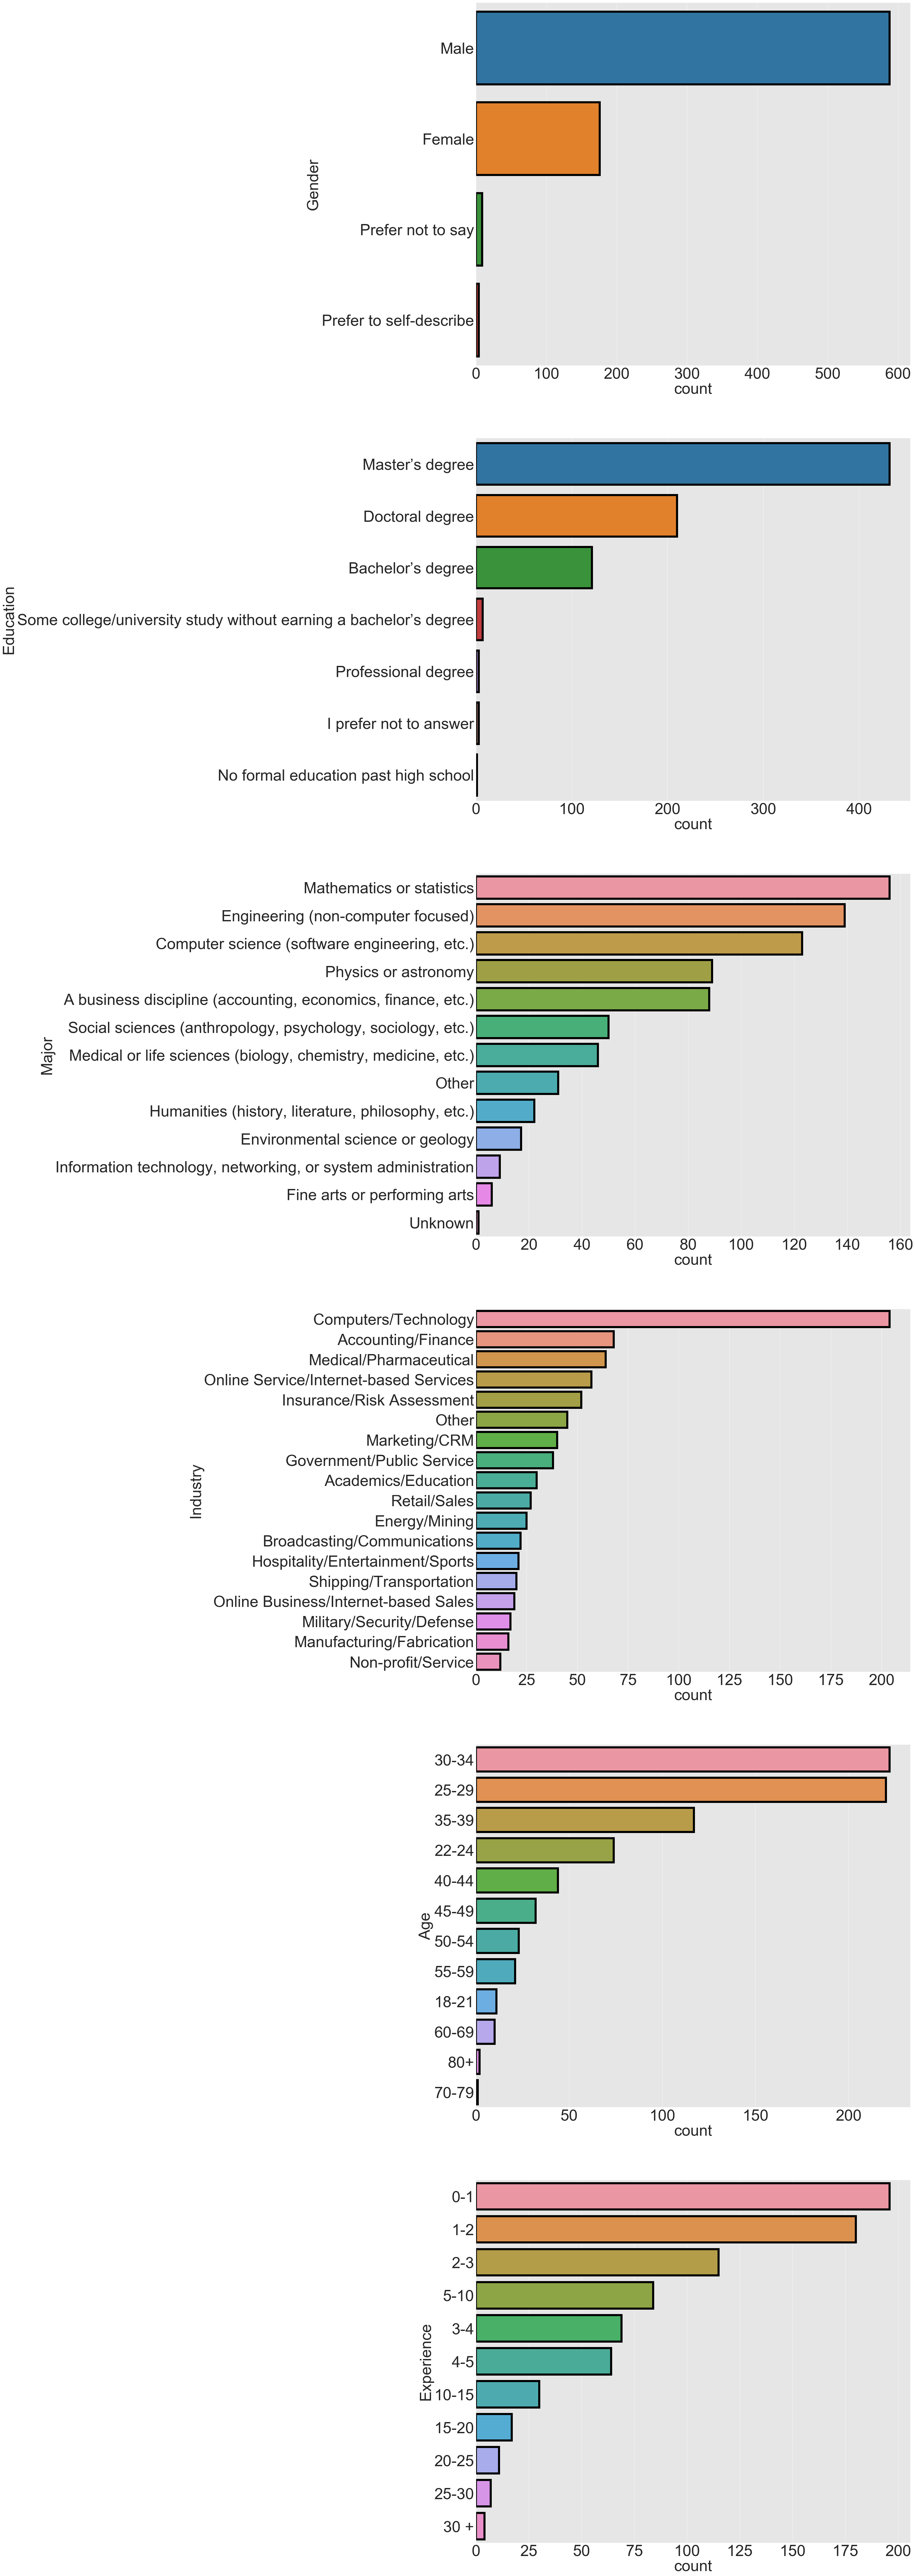

In [8]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
mpl.rcParams['font.size'] = 60.0
cols = df.columns
num_of_plots = len(cols) - 4
fig, ax = plt.subplots(num_of_plots,1, figsize=(5*num_of_plots, 30*num_of_plots))

z = 0
for column in df.columns[:num_of_plots]:
    sns.countplot(y = df[column], edgecolor = "black", 
                  linewidth = 8, ax = ax[z], order=df[column].value_counts().index)
    z += 1     
fig.show()

In [9]:
df = df[(df.Gender=="Male") | 
         (df.Gender=="Female")
        ]

# the apostrophes used below are not the standard ones used on a keyboard
# I copy and pasted the bachelors and masters text below from a value_counts print
df = df[(df.Education=="Bachelor’s degree") | 
          (df.Education=="Master’s degree") |
          (df.Education=="Doctoral degree")
         ]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751 entries, 11 to 23536
Data columns (total 10 columns):
Gender            751 non-null object
Education         751 non-null object
Major             751 non-null object
Industry          751 non-null object
Age               751 non-null object
Experience        751 non-null object
Salary            751 non-null object
Age_Mid           751 non-null float64
Experience_Mid    751 non-null float64
Sal_Mid           751 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 64.5+ KB


In [10]:
dictionary = {'Master’s degree'    : "Master's", 
              'Bachelor’s degree'  : "Bachelor's",
              'Doctoral degree'    : "Doctoral"
             }
df.Education = df.Education.apply(lambda x: dictionary[x])

dictionary = {'Social sciences (anthropology, psychology, sociology, etc.)'   : 'Social Sci',
              'Mathematics or statistics'                                     : 'Math/Stats', 
              'Engineering (non-computer focused)'                            : 'Engineering',
              'Computer science (software engineering, etc.)'                 : 'Comp Sci',
              'Physics or astronomy'                                          : 'Phys/Astron',
              'A business discipline (accounting, economics, finance, etc.)'  : 'Business',
              'Medical or life sciences (biology, chemistry, medicine, etc.)' : 'Medic Sci',
              'Fine arts or performing arts'                                  : 'Other',
              'Information technology, networking, or system administration'  : 'Other',
              'Environmental science or geology'                              : 'Other', 
              'Other'                                                         : 'Other',
              'Humanities (history, literature, philosophy, etc.)'            : 'Other',
              'I never declared a major'                                      : 'Other',
              'Unknown'                                                       : 'Other'
             }
df['Major'] = df['Major'].apply(lambda x: dictionary[x])

dictionary = {'Other'                                  : "Other",
              'Marketing/CRM'                          : "Marketing", 
              'Insurance/Risk Assessment'              : "Risk_Asse",
              'Computers/Technology'                   : "Technology", 
              'Broadcasting/Communications'            : "Other",
              'Academics/Education'                    : "Other", 
              'Accounting/Finance'                     : "Finance",
              'Medical/Pharmaceutical'                 : "Medical", 
              'Non-profit/Service'                     : "Other",
              'Online Service/Internet-based Services' : "Online_Serv",
              'Shipping/Transportation'                : "Other", 
              'Energy/Mining'                          : "Other", 
              'Retail/Sales'                           : "Other" ,
              'Military/Security/Defense'              : "Other",
              'Online Business/Internet-based Sales'   : "Other",
              'Manufacturing/Fabrication'              : "Other", 
              'Government/Public Service'              : "Government",
              'Hospitality/Entertainment/Sports'       : "Other"
             }
df['Industry'] = df['Industry'].apply(lambda x: dictionary[x])  
                    
#Age
dictionary = {'18-21' : "Other",
              '22-24' : '22-24',
              '25-29' : '25-29',
              '30-34' : '30-34',
              '35-39' : '35-39',
              '40-44' : '40-44',
              '45-49' : '45-49',
              '50-54' : "Other",
              '55-59' : "Other",
              '60-69' : "Other",
              '70-79' : "Other",
              '80+'   : "Other"
             }
df['Age'] = df['Age'].apply(lambda x: dictionary[x])

#Experience for linear regession
dictionary = {'0-1'    : '0-1',
              '1-2'    : '1-2',
              '2-3'    : '2-3',
              '3-4'    : '3-4',
              '4-5'    : '4-5',
              '5-10'   : '5-10',
              '10-15'  : '>10',
              '15-20'  : '>10',
              '20-25'  : '>10',
              '25-30'  : '>10',
              '30 +'   : '>10'
            }
df['Experience'] = df['Experience'].apply(lambda x: dictionary[x])

#For logistic regression
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

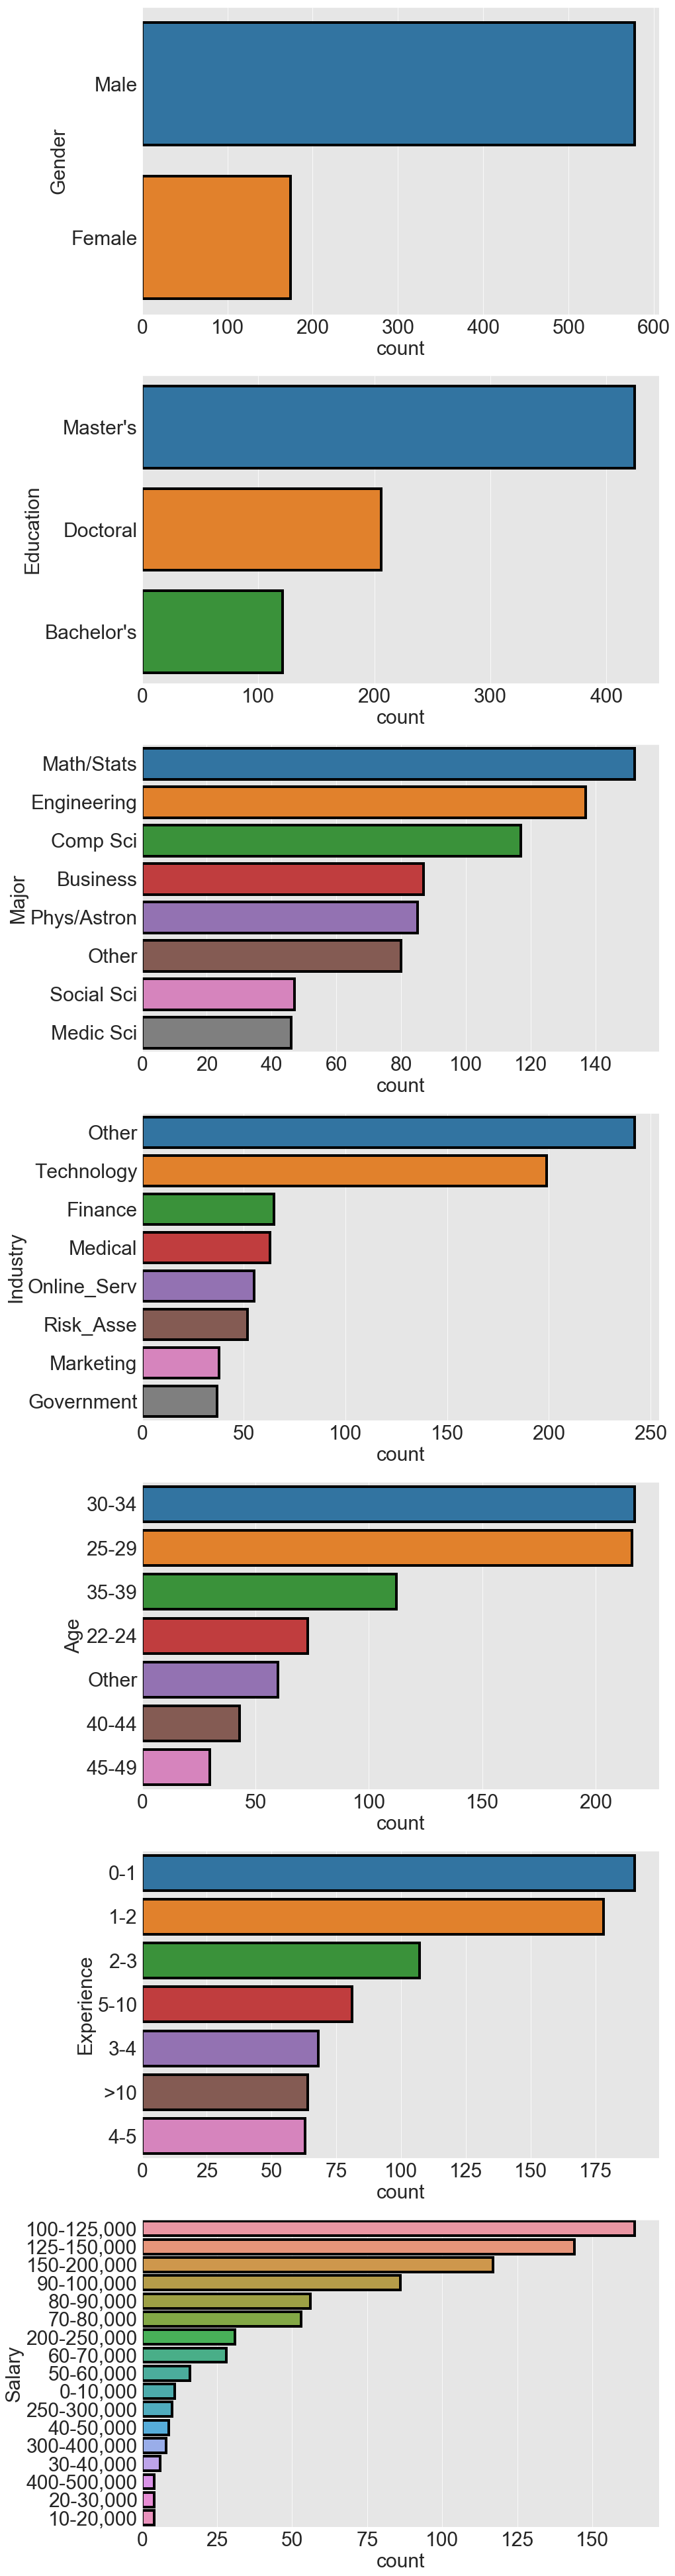

In [11]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
mpl.rcParams['font.size'] = 30.0
cols = df.columns
num_of_plots = len(cols) - 4
fig, ax = plt.subplots(num_of_plots,1, figsize=(2*num_of_plots, 10*num_of_plots))

z = 0
for column in df.columns[:num_of_plots]:
    sns.countplot(y = df[column], edgecolor = "black", 
                  linewidth = 4, ax = ax[z], order=df[column].value_counts().index)
    z += 1     
fig.show()

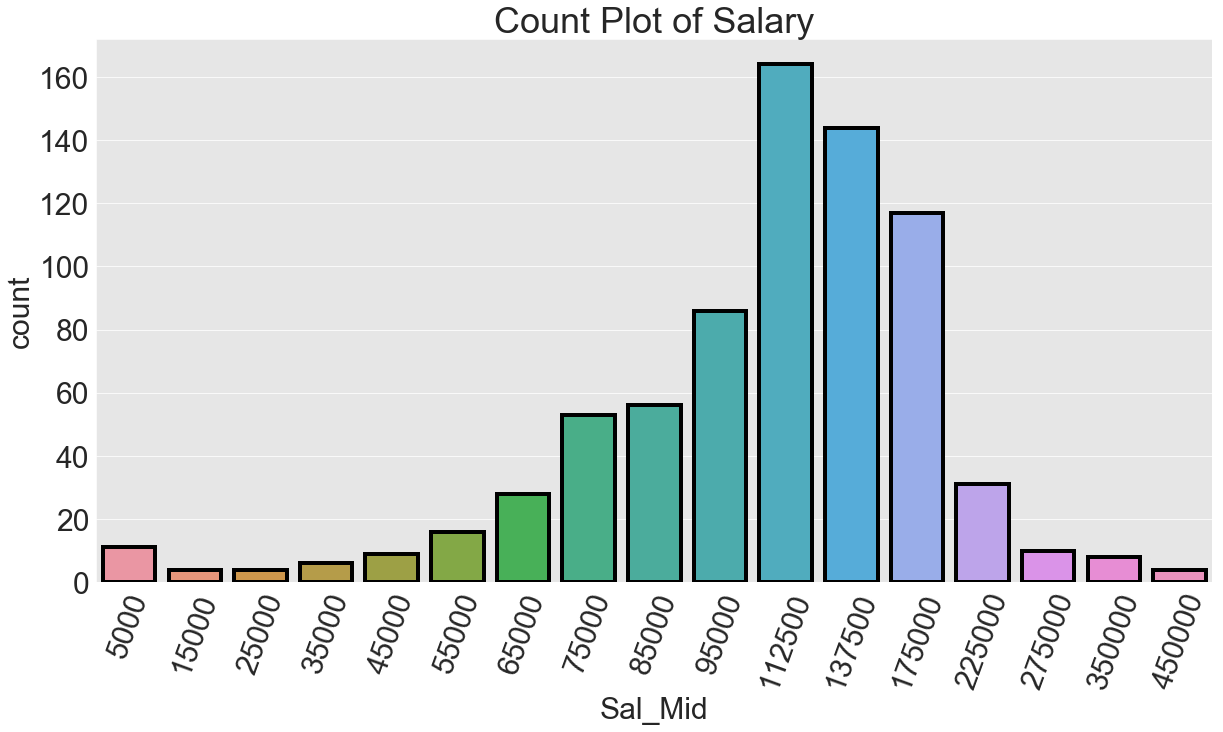

In [12]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(20, 10))
mpl.rcParams['font.size'] = 30.0
sns.countplot(x=df.Sal_Mid, edgecolor="black", linewidth=4,)
plt.title("Count Plot of Salary")
plt.xticks(rotation=70)
plt.show()

<div class = "span alert alert-success">
    <h2> User-Defined Functions for Statistics</h2>
    </div>

In [13]:
def sorted_by_mean(df, by, column):
    #example: sorted_by_mean(df, "Major", "Sal_Mid")
    df = pd.DataFrame({col:vals[column] for 
                        col, vals in 
                        df.groupby([by])}).mean().sort_values(ascending=False)
    return df.index

def t_test(df, column, a, b):
    # example: ttest(df,"Education","Bachelor's","Master's")  
    fea_a = df[df[column] == a]
    fea_b = df[df[column] == b]
    t,p = stats.ttest_ind(fea_a.Sal_Mid,
                          fea_b.Sal_Mid, 
                          equal_var = False)
    print(a, "vs", b, "p-value:", "{:.3f}".format(p))

def plot(df, column, order, palette):
    # example boxplot(df, "Experience", exp_order, "Blues_r")
    if palette == "Blues_r":
        title = "(Averaged Salaries)"
        
    if palette == "Greens_r":
        title = "(Salary > Median)"
        
    if palette == "Reds_r":
        title = "(Salary <= Median)"
        
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize = (20, 12))
    mpl.rcParams['font.size'] = 30

    ax = sns.boxplot(x = df["Sal_Mid"], y = df[column], notch = True,
                     linewidth = 4, palette = palette, order = order, showmeans=True, 
                     meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", 
                                      "markeredgewidth":4 ,"markersize":20})
    
#     medians = df.groupby([column])["Sal_Mid"].median()
#     medians = medians[order].values
#     nobs = df[column].value_counts()
#     nobs = nobs[order].values
#     nobs = [str(x) for x in nobs.tolist()]
#     nobs = [i for i in nobs]
#     pos = range(len(nobs))
#     for tick,label in zip(pos,ax.get_xticklabels()):
#         ax.text(medians[tick], pos[tick], nobs[tick], 
#                 bbox=dict(facecolor='black', alpha=0.5),
#                 horizontalalignment='left', verticalalignment='bottom',
#                 size='small', color='white', weight='bold')
        
#     sns.swarmplot(x = df["Sal_Mid"], y = df[column],
#                 linewidth = 4, color="grey", order = order)

    plt.xlim(0,400000)
    plt.title(column + " vs Salary " + title)
    #if palette == "Blues_r":
    #    plt.axvline(df["Sal_Mid"].median(), color = 'r', linestyle = '-', linewidth= 8)
    return plt.show()

def tukey(df,feature):
    mc = MultiComparison(df["Sal_Mid"], df[feature])
    print(mc.tukeyhsd())

<div class = "span alert alert-success">
    <h2> Variable assignments for Statistics </h2>
    </div>

In [14]:
top_df = df[df.Sal_Mid>df.Sal_Mid.median()]
btm_df = df[df.Sal_Mid<=df.Sal_Mid.median()]

exp_order = (['>10','5-10','4-5','3-4','2-3','1-2','0-1'])

edu_order = (["Doctoral","Master's","Bachelor's"])

gen_order = (["Male","Female"])

age_order = (['45-49', '40-44','35-39','30-34', '25-29','22-24', 'Other'])

maj_order= sorted_by_mean(df, "Major", "Sal_Mid")

ind_order= sorted_by_mean(df, "Industry", "Sal_Mid")

<div class = "span alert alert-success">
    <h2> Boxplots and Statistics </h2>
    </div>

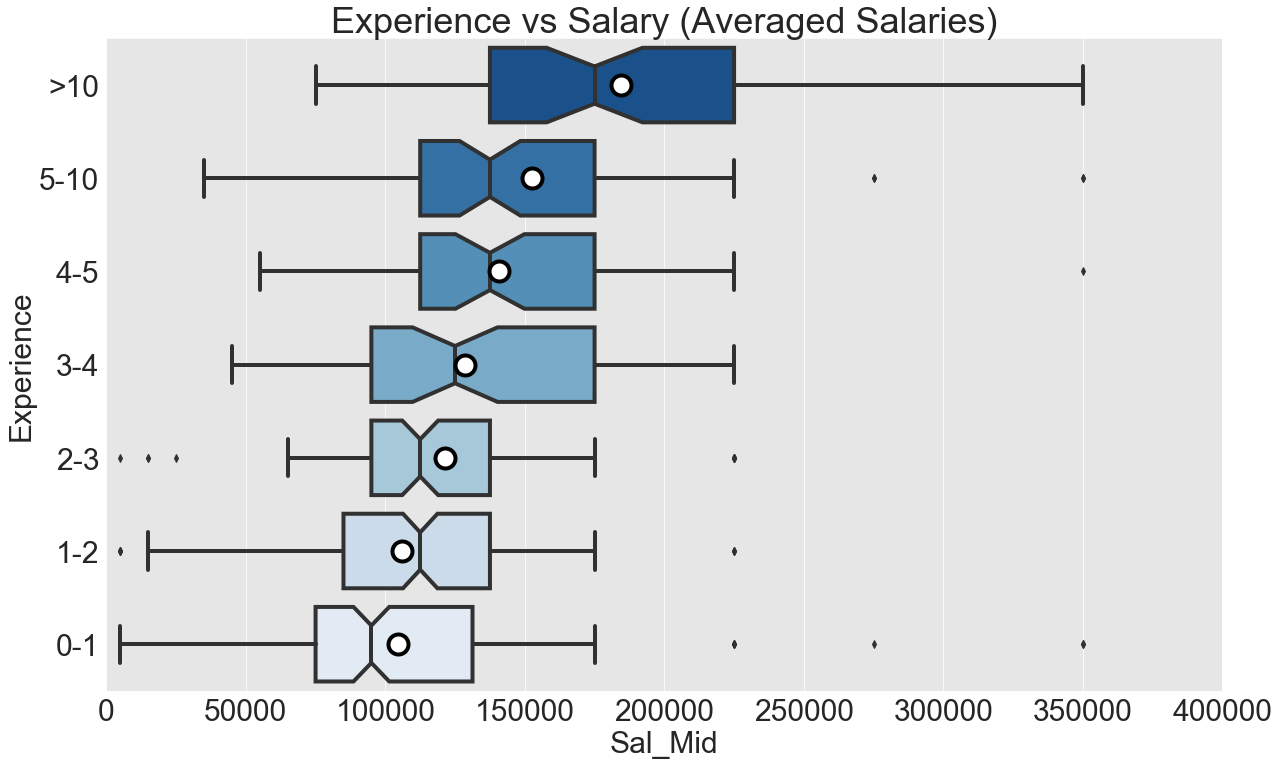

  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
group1 group2  meandiff     lower      upper    reject
------------------------------------------------------
 0-1    1-2   1415.5825  -14909.8615 17741.0265 False 
 0-1    2-3   16932.4889  -1983.8649 35848.8428 False 
 0-1    3-4   24026.7028  1910.7074  46142.6981  True 
 0-1    4-5   36055.7644  13302.638  58808.8908  True 
 0-1    5-10  47991.3905  27223.4596 68759.3214  True 
 0-1    >10   79991.7763  57372.5386 102611.014  True 
 1-2    2-3   15516.9064  -3627.7878 34661.6007 False 
 1-2    3-4   22611.1203   299.5062  44922.7344  True 
 1-2    4-5   34640.1819  11696.8684 57583.4954  True 
 1-2    5-10  46575.808   25599.6829 67551.9332  True 
 1-2    >10   78576.1938  55765.6526 101386.735  True 
 2-3    3-4   7094.2139  -17177.5073 31365.935  False 
 2-3    4-5   19123.2755  -5730.3753 43976.9262 False 
 2-3    5-10  31058.9016  8008.8225  54108.9807  True 
 2-3    >10   63059.2874  38328.1509 87790.4238  True 
 3-4    4-

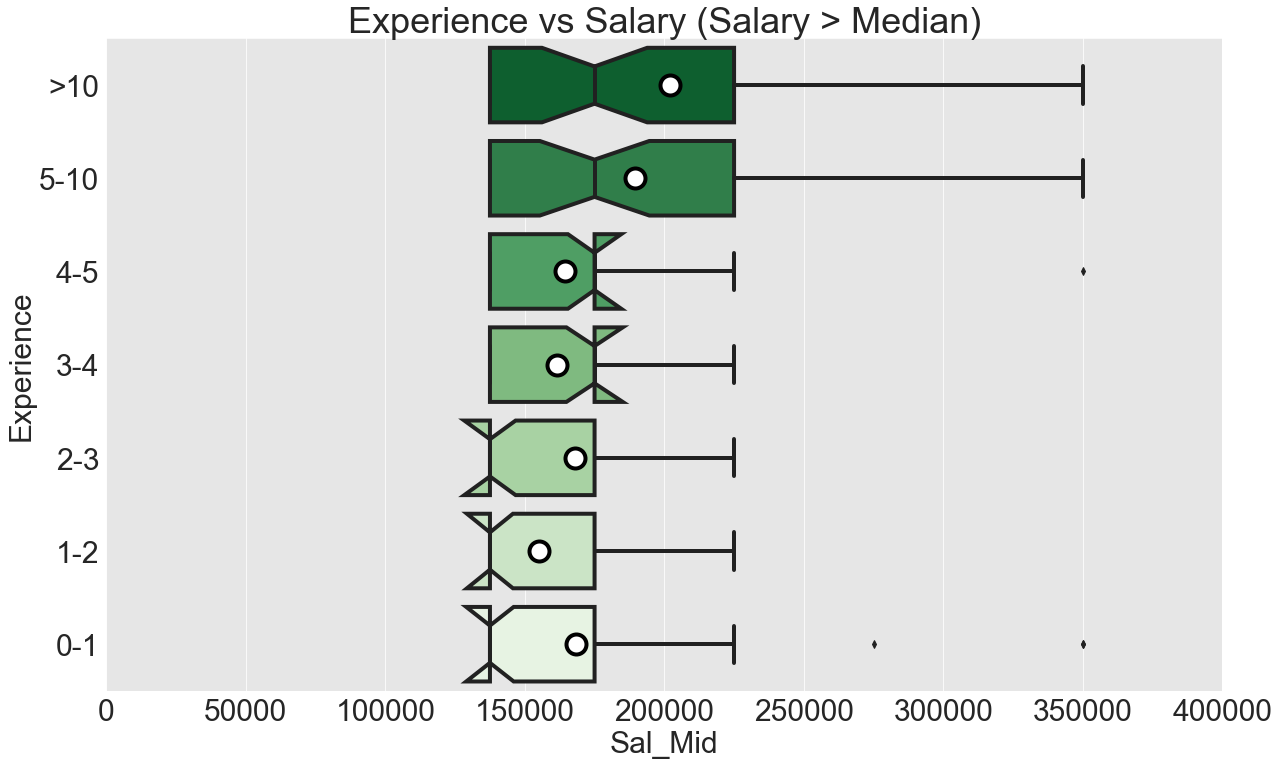

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
group1 group2   meandiff     lower      upper    reject
-------------------------------------------------------
 0-1    1-2   -13082.1078 -44377.0792 18212.8635 False 
 0-1    2-3    -241.3618  -33335.0464 32852.3228 False 
 0-1    3-4    -6832.1078 -41714.7615 28050.5458 False 
 0-1    4-5    -3755.4825 -37546.3604 30035.3955 False 
 0-1    5-10   21311.6497 -10291.4642 52914.7635 False 
 0-1    >10    33657.6258  2650.2651  64664.9864  True 
 1-2    2-3    12840.7461 -19801.4647 45482.9568 False 
 1-2    3-4      6250.0   -28204.6294 40704.6294 False 
 1-2    4-5    9326.6254  -24022.2186 42675.4694 False 
 1-2    5-10   34393.7575  3263.7275  65523.7875  True 
 1-2    >10    46739.7336  16214.6886 77264.7787  True 
 2-3    3-4    -6590.7461 -42686.9816 29505.4895 False 
 2-3    4-5    -3514.1207 -38556.4112 31528.1699 False 
 2-3    5-10   21553.0114 -11384.7404 54490.7633 False 
 2-3    >10    33898.9876  1532.4136  66265.5615

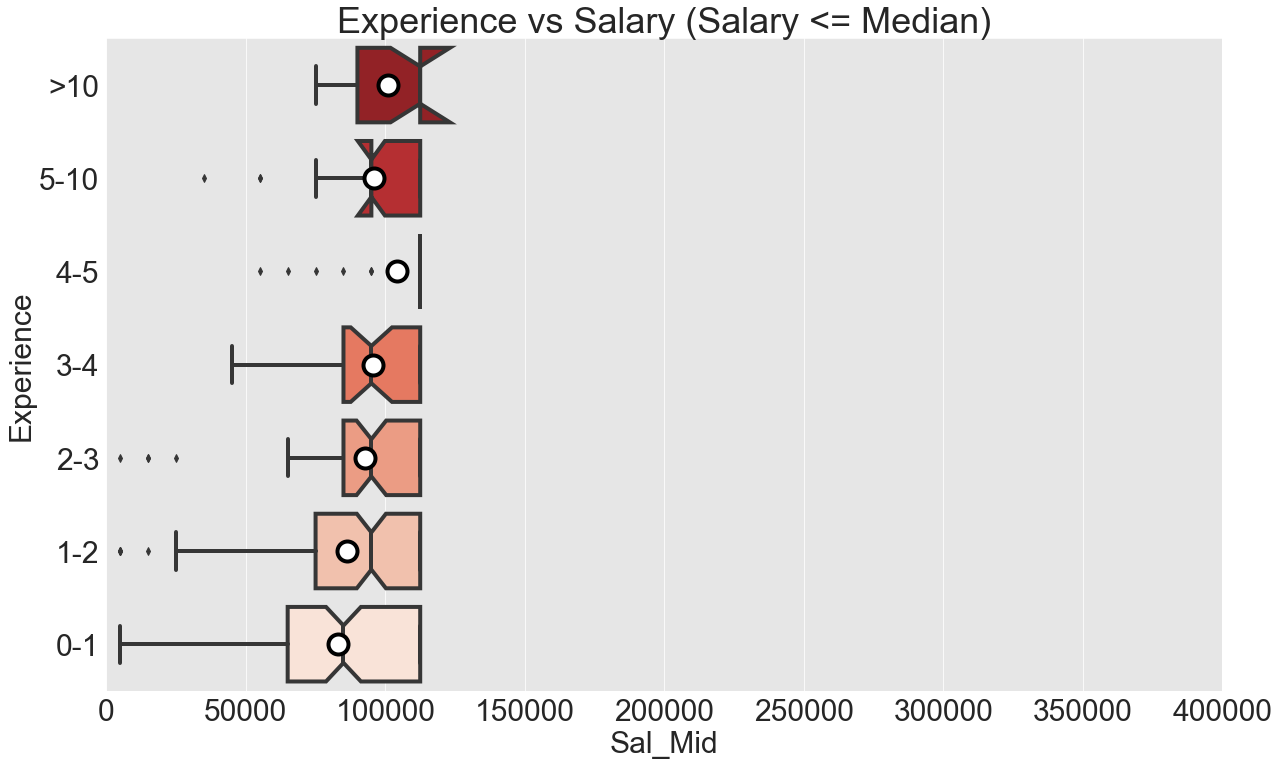

  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
group1 group2  meandiff     lower      upper    reject
------------------------------------------------------
 0-1    1-2    3190.224   -5925.9483 12306.3963 False 
 0-1    2-3   9565.1942   -1554.6306 20685.019  False 
 0-1    3-4   12724.7307  -1526.5902 26976.0517 False 
 0-1    4-5   21289.4366   5100.196  37478.6772  True 
 0-1    5-10  12848.8116  -1757.4098 27455.0331 False 
 0-1    >10   17898.5275  -5462.2675 41259.3225 False 
 1-2    2-3   6374.9702   -4951.3085 17701.2489 False 
 1-2    3-4   9534.5067   -4878.4817 23947.4951 False 
 1-2    4-5   18099.2126  1767.4767  34430.9485  True 
 1-2    5-10  9658.5876   -5105.4156 24422.5908 False 
 1-2    >10   14708.3035  -8751.4669 38168.074  False 
 2-3    3-4   3159.5365  -12597.3712 18916.4443 False 
 2-3    4-5   11724.2424  -5804.9191 29253.4039 False 
 2-3    5-10  3283.6174  -12794.9925 19362.2273 False 
 2-3    >10   8333.3333   -15975.24  32641.9066 False 
 3-4    4-

In [15]:
plot(df, "Experience", exp_order, "Blues_r")
tukey(df, "Experience")

plot(top_df, "Experience", exp_order, "Greens_r")
tukey(top_df, "Experience")

plot(btm_df, "Experience", exp_order, "Reds_r")
tukey(btm_df, "Experience")

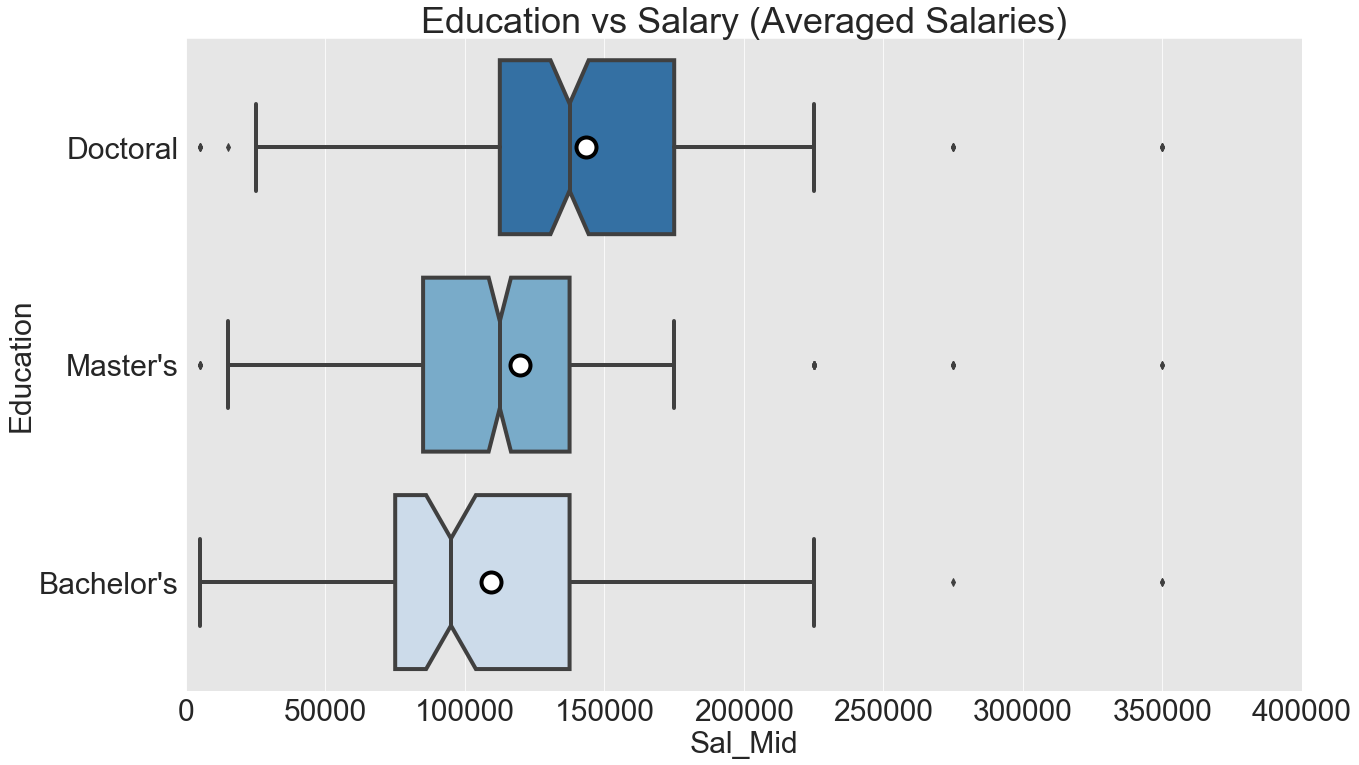

      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
  group1    group2    meandiff     lower       upper    reject
--------------------------------------------------------------
Bachelor's Doctoral  33913.5842  18599.5349  49227.6335  True 
Bachelor's Master's  10342.7608  -3437.743   24123.2646 False 
 Doctoral  Master's -23570.8234 -34926.0602 -12215.5866  True 
--------------------------------------------------------------

Bachelor's vs Master's p-value: 0.063
Master's vs Doctoral p-value: 0.000
Bachelor's vs Doctoral p-value: 0.000

Bachelor's
          Age_Mid  Experience_Mid        Sal_Mid
count  121.000000      121.000000     121.000000
mean    28.855372        3.033058  109338.842975
std      8.046334        4.590632   53943.226902
min     19.500000        0.500000    5000.000000
25%     23.000000        0.500000   75000.000000
50%     27.000000        1.500000   95000.000000
75%     32.000000        3.500000  137500.000000
max     64.500000       30.000000  350000.

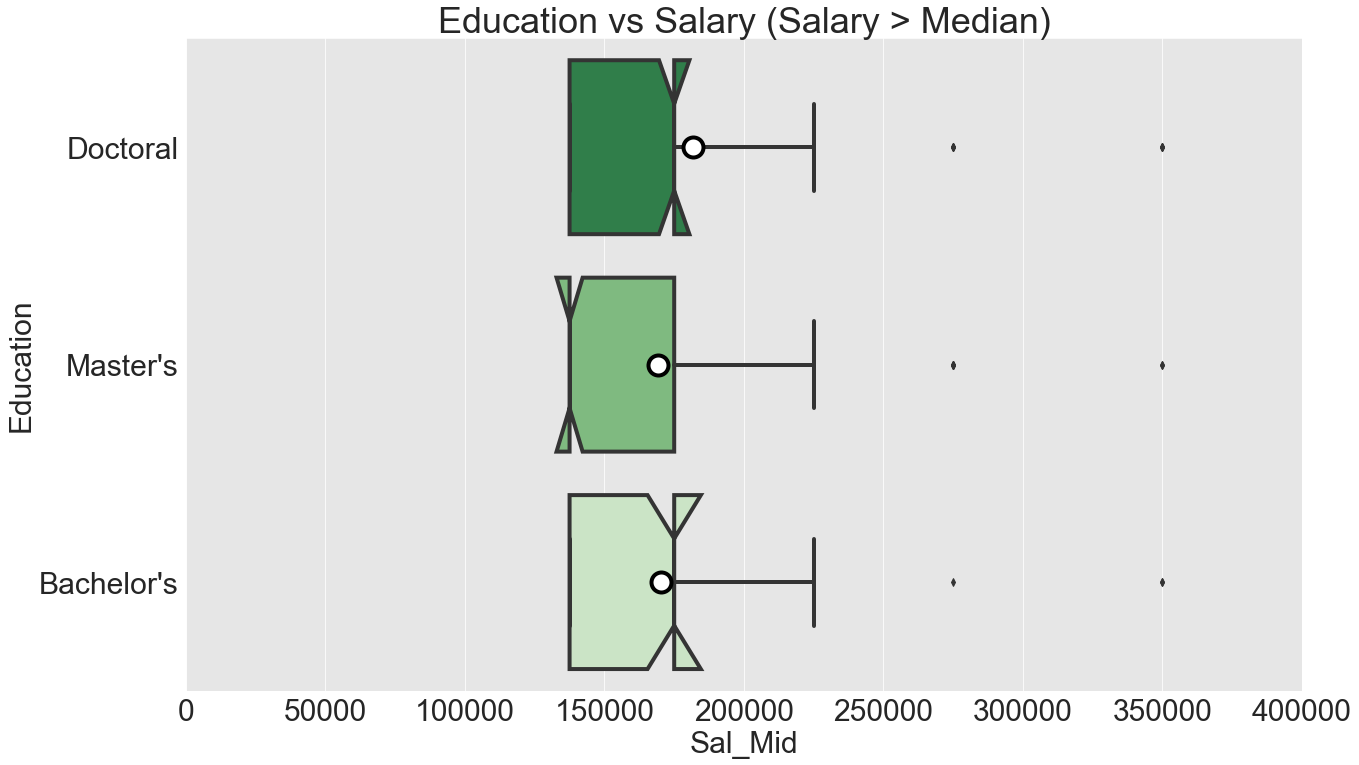

      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
  group1    group2    meandiff     lower      upper    reject
-------------------------------------------------------------
Bachelor's Doctoral  11229.1948 -12634.2137 35092.6033 False 
Bachelor's Master's  -1369.5796 -24447.3638 21708.2046 False 
 Doctoral  Master's -12598.7744 -28166.1141 2968.5654  False 
-------------------------------------------------------------

Bachelor's vs Master's p-value: 0.883
Master's vs Doctoral p-value: 0.066
Bachelor's vs Doctoral p-value: 0.266

Bachelor's
         Age_Mid  Experience_Mid        Sal_Mid
count  38.000000       38.000000      38.000000
mean   33.065789        5.236842  170394.736842
std     9.235779        5.578357   51532.351148
min    19.500000        0.500000  137500.000000
25%    27.000000        1.750000  137500.000000
50%    32.000000        3.500000  175000.000000
75%    35.750000        4.500000  175000.000000
max    57.000000       22.500000  350000.000000

Master's

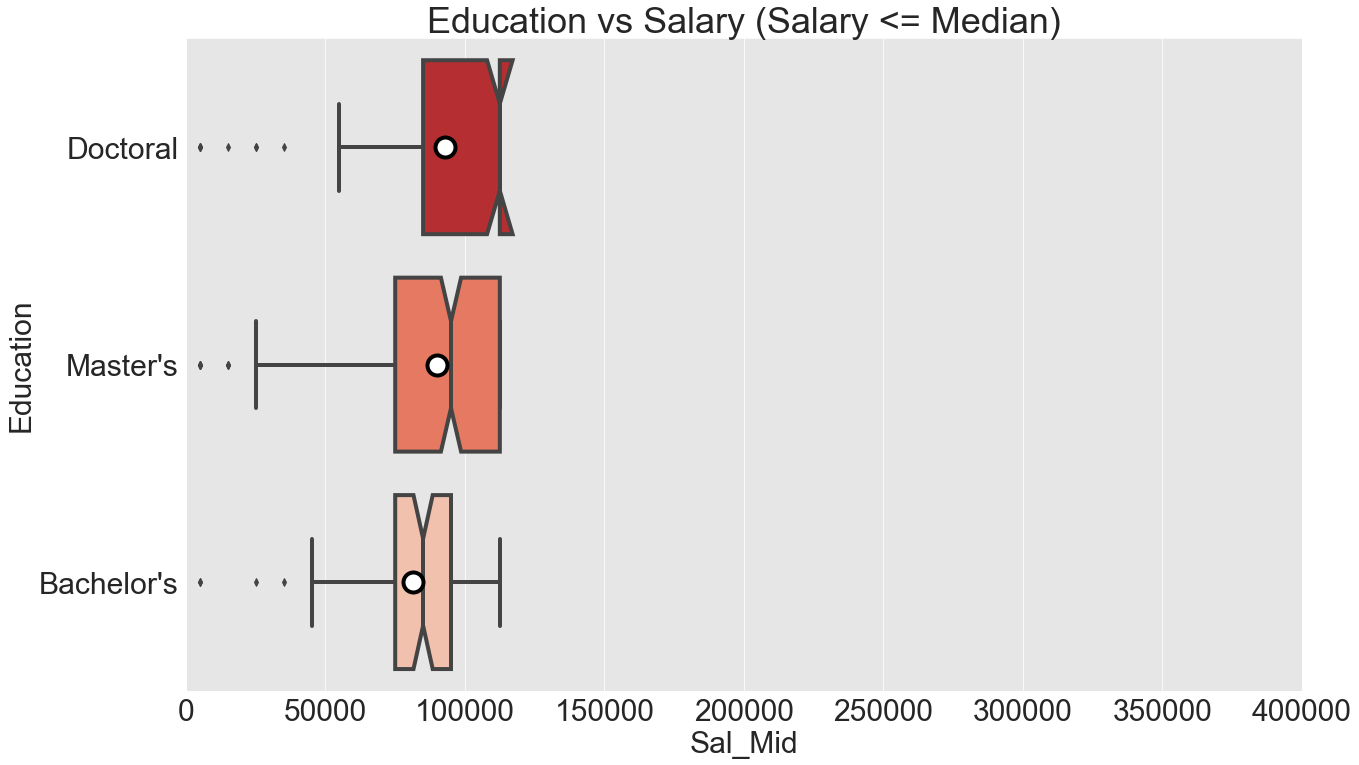

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
  group1    group2   meandiff    lower      upper    reject
-----------------------------------------------------------
Bachelor's Doctoral 11423.4466 2243.3224  20603.5708  True 
Bachelor's Master's 8689.9295  1122.5412  16257.3179  True 
 Doctoral  Master's -2733.5171 -10104.104 4637.0699  False 
-----------------------------------------------------------

Bachelor's vs Master's p-value: 0.004
Master's vs Doctoral p-value: 0.430
Bachelor's vs Doctoral p-value: 0.005

Bachelor's
         Age_Mid  Experience_Mid        Sal_Mid
count  83.000000       83.000000      83.000000
mean   26.927711        2.024096   81385.542169
std     6.654419        3.676643   23273.470359
min    19.500000        0.500000    5000.000000
25%    23.000000        0.500000   75000.000000
50%    27.000000        1.500000   85000.000000
75%    27.000000        2.000000   95000.000000
max    64.500000       30.000000  112500.000000

Master's
          Age

In [16]:
plot(df, "Education", edu_order, "Blues_r")
tukey(df,"Education")
print("")
t_test(df,"Education","Bachelor's","Master's")
t_test(df,"Education","Master's","Doctoral")    
t_test(df,"Education","Bachelor's","Doctoral")  

print("")
print("Bachelor's")
print(df[(df.Education=="Bachelor's")].describe())
print("")
print("Master's")
print(df[(df.Education=="Master's")].describe())
print("")
print("Doctoral")
print(df[(df.Education=="Doctoral")].describe())

plot(top_df, "Education", edu_order, "Greens_r")
tukey(top_df,"Education")
print("")
t_test(top_df,"Education","Bachelor's","Master's")
t_test(top_df,"Education","Master's","Doctoral")    
t_test(top_df,"Education","Bachelor's","Doctoral")  


print("")
print("Bachelor's")
print(top_df[(top_df.Education=="Bachelor's")].describe())
print("")
print("Master's")
print(top_df[(top_df.Education=="Master's")].describe())
print("")
print("Doctoral")
print(top_df[(top_df.Education=="Doctoral")].describe())

plot(btm_df, "Education", edu_order, "Reds_r")
tukey(btm_df,"Education")
print("")
t_test(btm_df,"Education","Bachelor's","Master's")
t_test(btm_df,"Education","Master's","Doctoral")    
t_test(btm_df,"Education","Bachelor's","Doctoral")  

print("")
print("Bachelor's")
print(btm_df[(btm_df.Education=="Bachelor's")].describe())
print("")
print("Master's")
print(btm_df[(btm_df.Education=="Master's")].describe())
print("")
print("Doctoral")
print(btm_df[(btm_df.Education=="Doctoral")].describe())

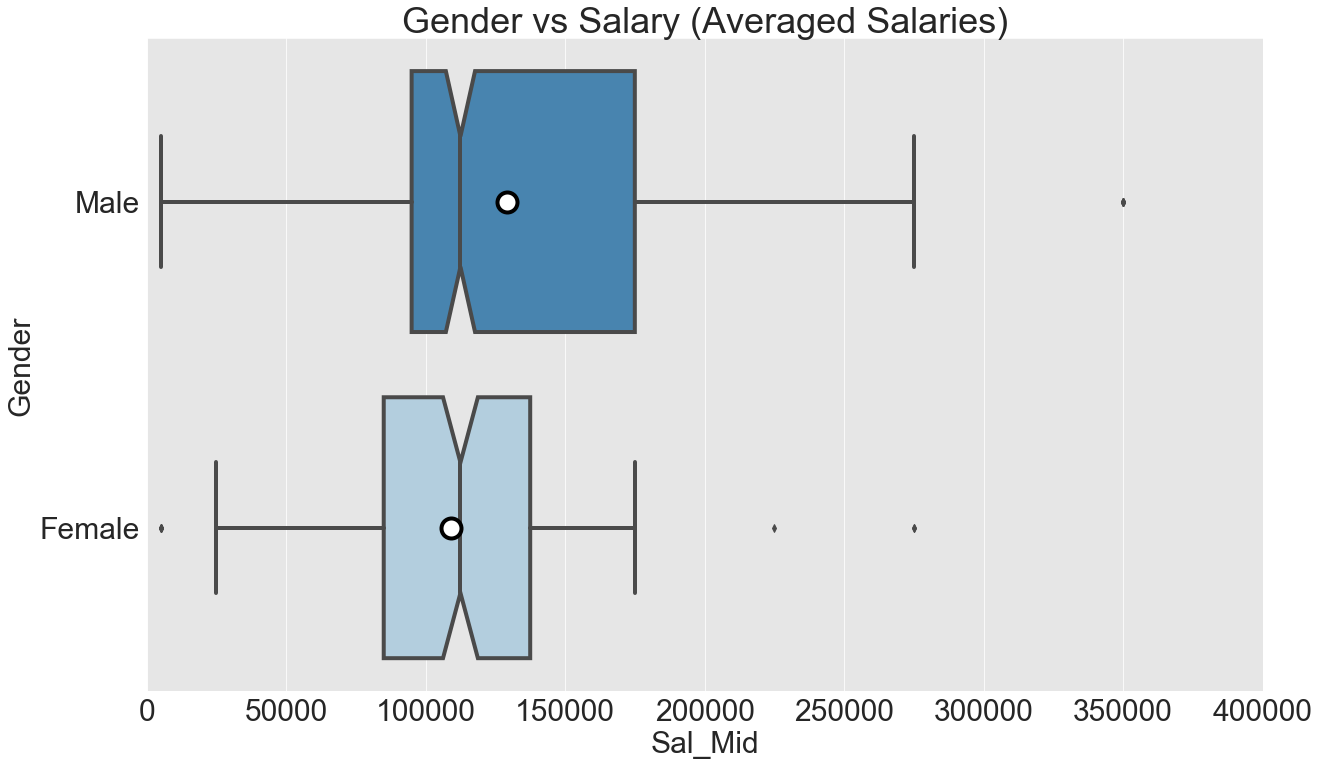


  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
Female  Male  19801.2162 10026.9114 29575.5209  True 
-----------------------------------------------------

Male vs Female p-value: 0.000


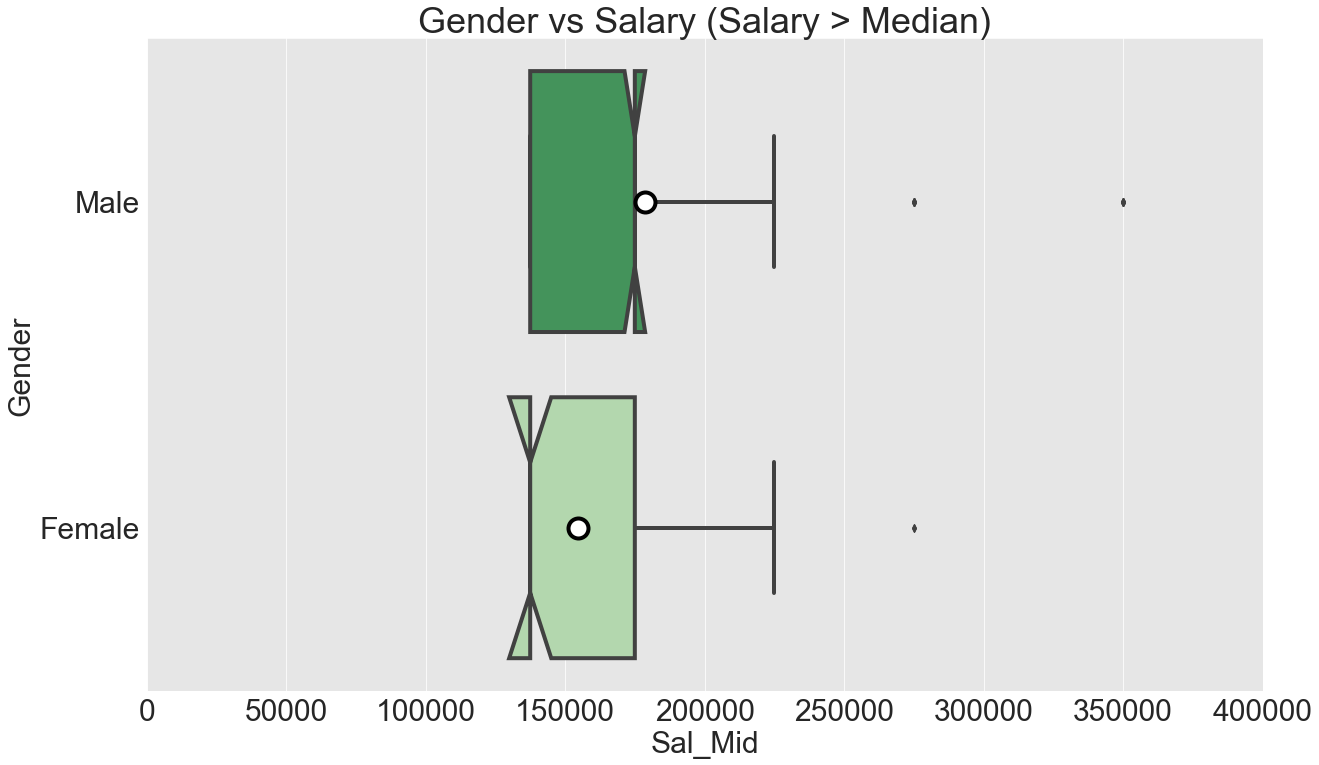


 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower     upper    reject
----------------------------------------------------
Female  Male  24049.1155 8986.4507 39111.7804  True 
----------------------------------------------------

Male vs Female p-value: 0.000


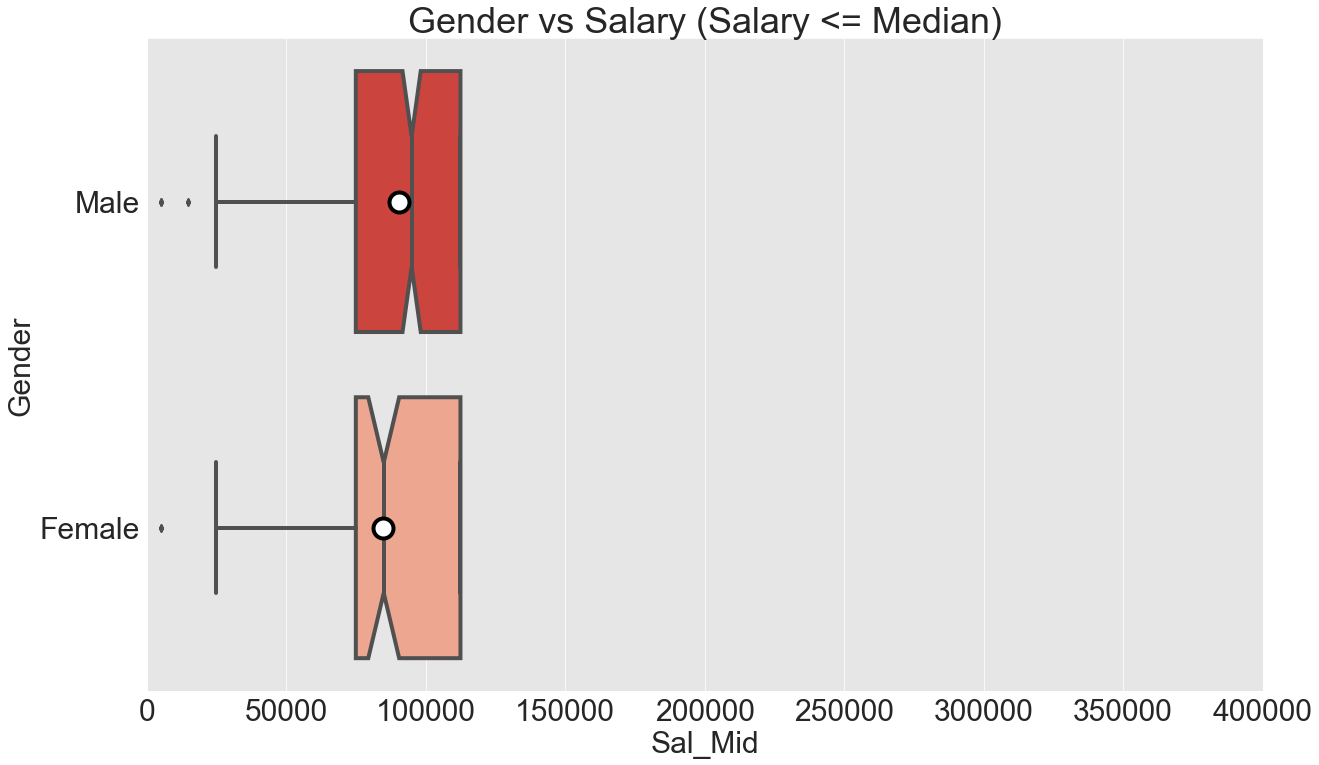


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
Female  Male  5579.25  56.1929 11102.307  True 
-----------------------------------------------

Male vs Female p-value: 0.054


In [17]:
plot(df, "Gender", gen_order, "Blues_r")
print("")
tukey(df,"Gender")
print("")
t_test(df,"Gender","Male","Female")


plot(top_df, "Gender", gen_order, "Greens_r")
print("")
tukey(top_df,"Gender")
print("")
t_test(top_df,"Gender","Male","Female")

plot(btm_df, "Gender", gen_order, "Reds_r")
print("")
tukey(btm_df,"Gender")
print("")
t_test(btm_df,"Gender","Male","Female")

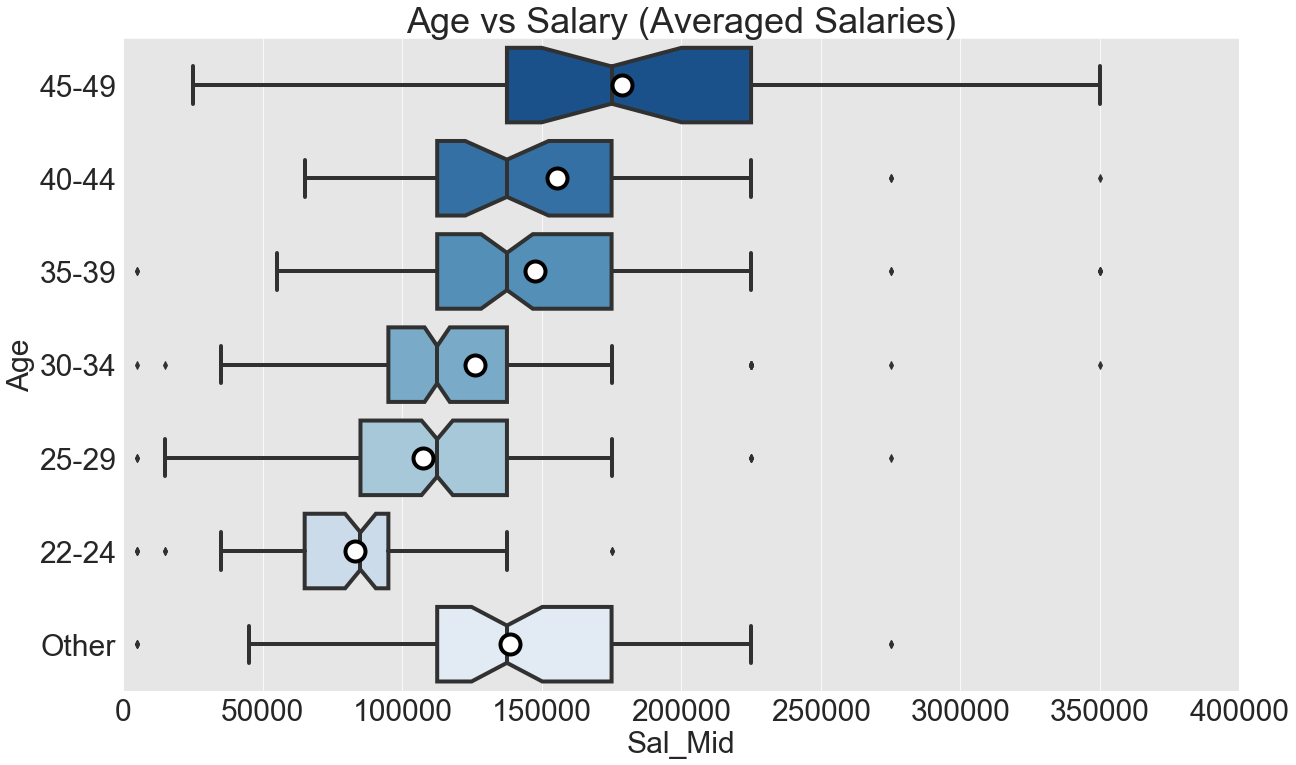

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower       upper    reject
--------------------------------------------------------
22-24  25-29   24414.9543  2934.4951   45895.4135  True 
22-24  30-34   43332.9651  21865.0115  64800.9187  True 
22-24  35-39   64578.6448  40711.6154  88445.6742  True 
22-24  40-44   72646.5435  42145.3887 103147.6983  True 
22-24  45-49   95956.621   61547.0308 130366.2112  True 
22-24  Other   55539.9543  27891.4457  83188.463   True 
25-29  30-34   18918.0108  3667.9999   34168.0216  True 
25-29  35-39   40163.6905  21688.7103  58638.6706  True 
25-29  40-44   48231.5891  21736.1133  74727.065   True 
25-29  45-49   71541.6667  40627.1119 102456.2214  True 
25-29  Other    31125.0    7970.5225   54279.4775  True 
30-34  35-39   21245.6797  2785.2411   39706.1184  True 
30-34  40-44   29313.5784  2828.2401   55798.9167  True 
30-34  45-49   52623.6559  21717.7891  83529.5227  True 
30-34  Other   12206.9892 -1093

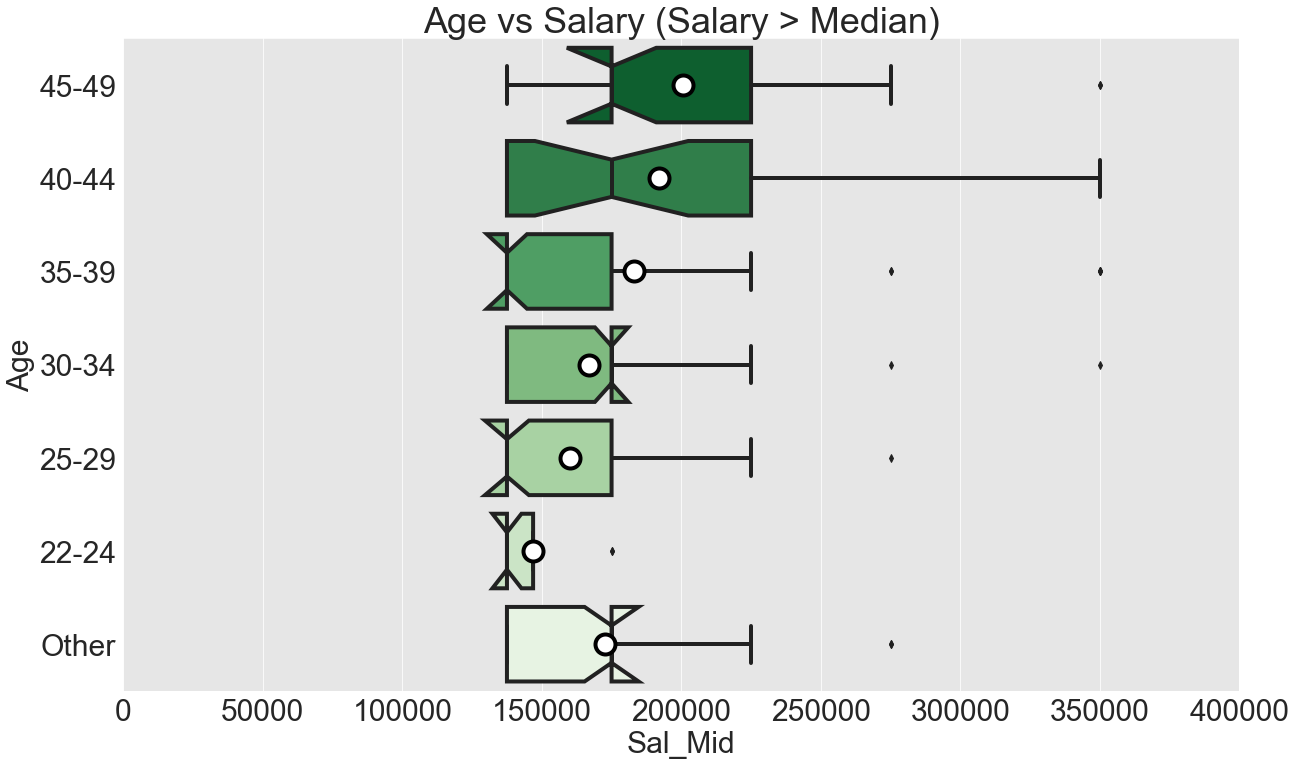

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower       upper    reject
--------------------------------------------------------
22-24  25-29   13392.8571 -46490.4065  73276.1207 False 
22-24  30-34   19877.5773 -38402.2518  78157.4065 False 
22-24  35-39   36333.9552 -22931.6492  95599.5597 False 
22-24  40-44    45125.0   -19232.0981 109482.0981 False 
22-24  45-49   53645.8333 -11035.4839 118327.1506 False 
22-24  Other   25760.1351 -36015.1676  87535.4379 False 
25-29  30-34   6484.7202   -20105.401  33074.8413 False 
25-29  35-39   22941.0981  -5745.2737  51627.4698 False 
25-29  40-44   31732.1429  -6377.3327  69841.6185 False 
25-29  45-49   40252.9762  1598.4957   78907.4566  True 
25-29  Other   12367.278  -21198.8371  45933.3931 False 
30-34  35-39   16456.3779  -8711.8789  41624.6347 False 
30-34  40-44   25247.4227 -10289.3942  60784.2396 False 
30-34  45-49   33768.256   -2352.4041  69888.9161 False 
30-34  Other   5882.5578  -2473

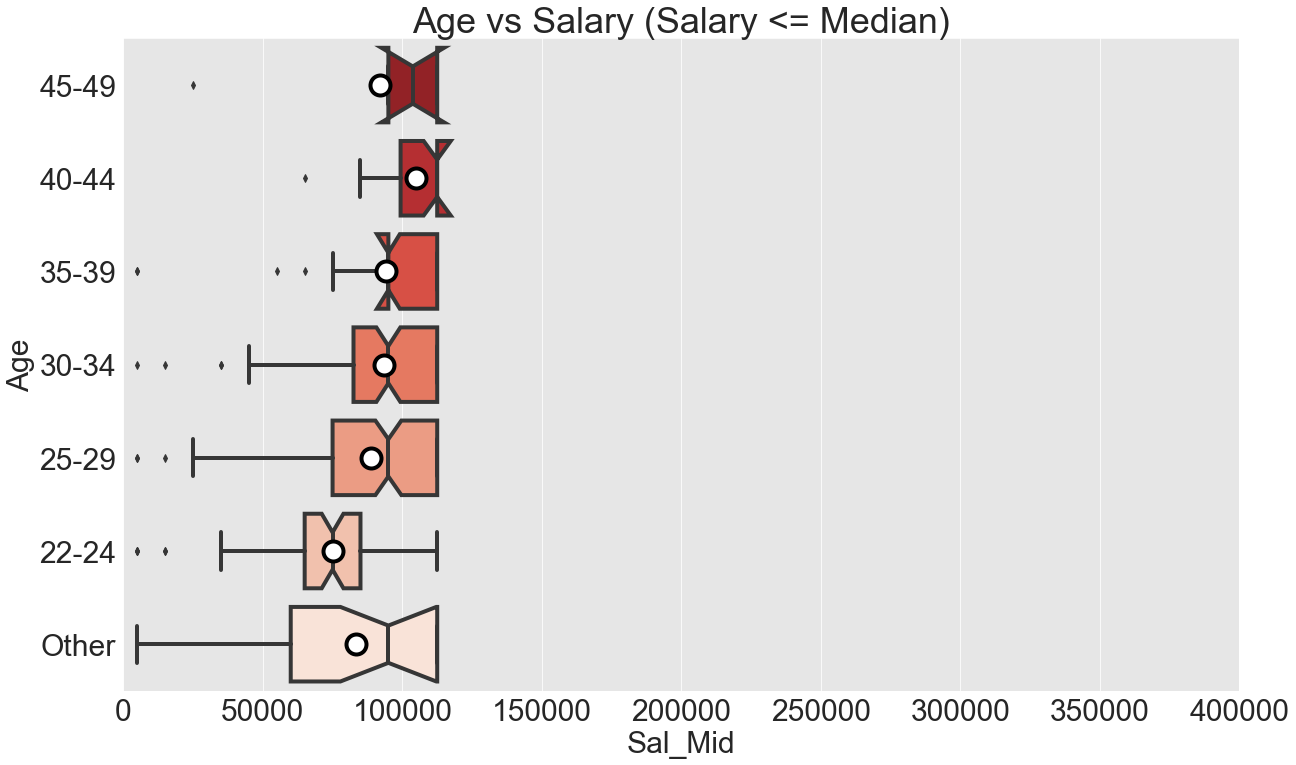

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
group1 group2   meandiff     lower      upper    reject
-------------------------------------------------------
22-24  25-29    13750.0    2857.1683  24642.8317  True 
22-24  30-34    18437.5    7032.2511  29842.7489  True 
22-24  35-39   19222.2222  4860.7285  33583.716   True 
22-24  40-44   29861.1111  10136.3242 49585.8981  True 
22-24  45-49   17083.3333  -14514.92  48681.5867 False 
22-24  Other   8369.5652   -9597.9055 26337.0359 False 
25-29  30-34     4687.5    -4255.7343 13630.7343 False 
25-29  35-39   5472.2222   -7023.9467 17968.3912 False 
25-29  40-44   16111.1111  -2299.9985 34522.2207 False 
25-29  45-49   3333.3333  -27461.9804 34128.6471 False 
25-29  Other   -5380.4348 -21895.0265 11134.1569 False 
30-34  35-39    784.7222  -12160.5533 13729.9977 False 
30-34  40-44   11423.6111  -7295.2263 30142.4486 False 
30-34  45-49   -1354.1667 -32334.4389 29626.1056 False 
30-34  Other  -10067.9348 -26924.9114 6789.0418 

In [18]:
plot(df, "Age", age_order, "Blues_r")
tukey(df,"Age")
plot(top_df, "Age", age_order, "Greens_r")
tukey(top_df,"Age")
plot(btm_df, "Age", age_order, "Reds_r")
tukey(btm_df,"Age")

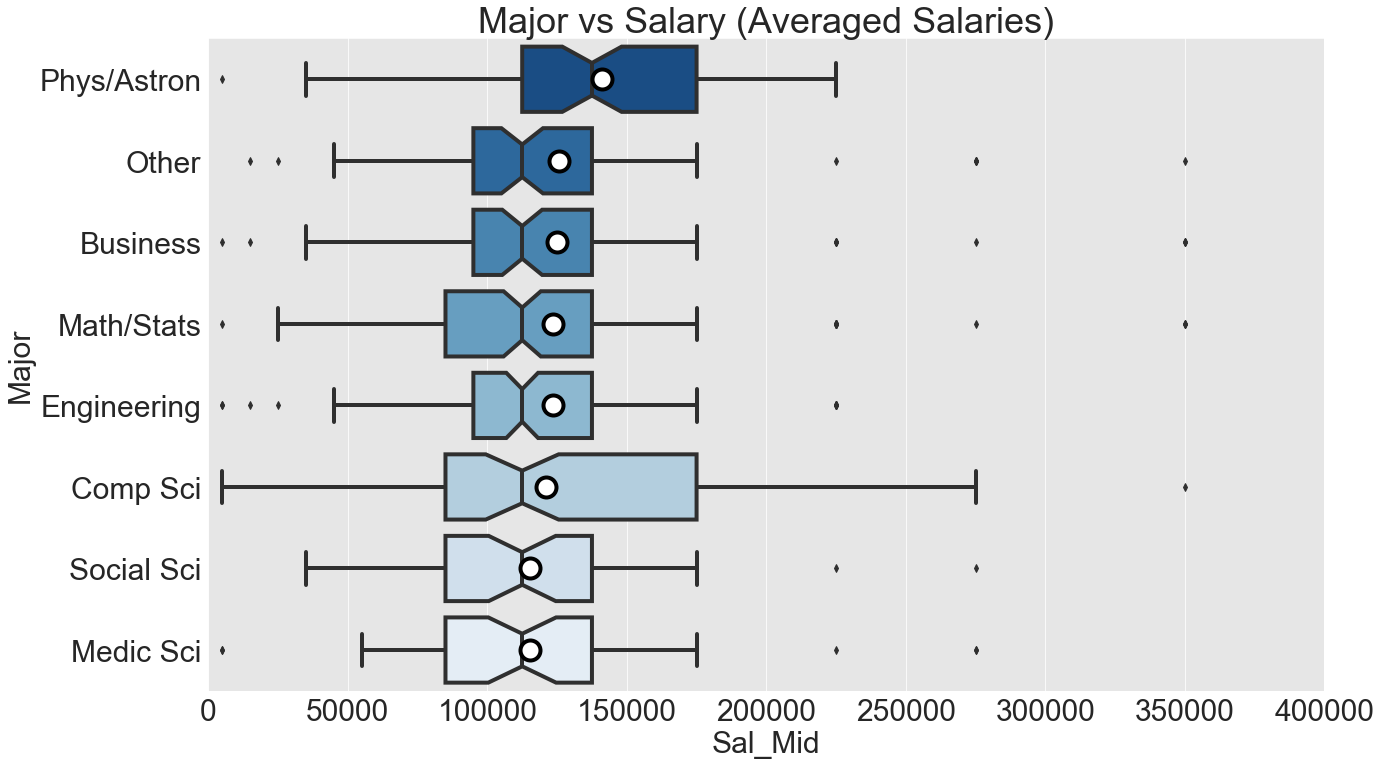

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
   group1      group2     meandiff     lower      upper    reject
-----------------------------------------------------------------
  Business    Comp Sci   -4046.5665 -29014.0523 20920.9194 False 
  Business  Engineering  -1666.0374 -25843.8154 22511.7406 False 
  Business   Math/Stats  -1644.5478 -25354.4529 22065.3573 False 
  Business   Medic Sci   -9951.8991  -42103.275 22199.4769 False 
  Business     Other      510.0575   -26809.012 27829.1269 False 
  Business  Phys/Astron  15943.881  -10953.3406 42841.1026 False 
  Business   Social Sci  -9848.9851 -41775.8394 22077.8692 False 
  Comp Sci  Engineering   2380.529  -19820.6444 24581.7025 False 
  Comp Sci   Math/Stats  2402.0187   -19288.688 24092.7253 False 
  Comp Sci   Medic Sci   -5905.3326 -36597.9723 24787.3071 False 
  Comp Sci     Other     4556.6239  -21029.6753 30142.9232 False 
  Comp Sci  Phys/Astron  19990.4475  -5144.9396 45125.8345 False 
  Comp Sci

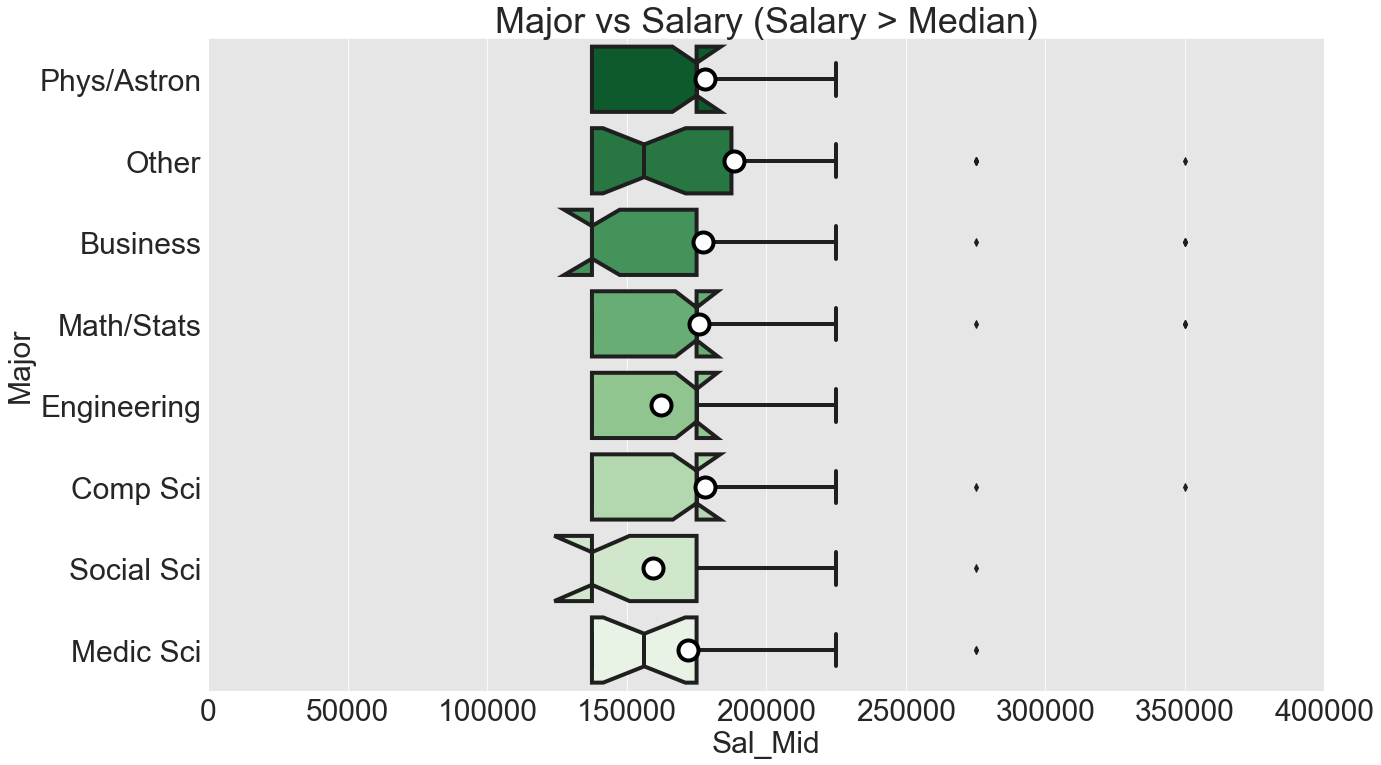

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
   group1      group2     meandiff     lower      upper    reject
-----------------------------------------------------------------
  Business    Comp Sci    982.1429  -35940.3359 37904.6216 False 
  Business  Engineering  -14844.47  -49965.1118 20276.1718 False 
  Business   Math/Stats  -1309.5238 -36640.7409 34021.6933 False 
  Business   Medic Sci   -5267.8571 -55397.8356 44862.1213 False 
  Business     Other      11250.0   -30867.6063 53367.6063 False 
  Business  Phys/Astron   846.2733  -36413.1402 38105.6868 False 
  Business   Social Sci -17932.3308 -65268.4338 29403.7721 False 
  Comp Sci  Engineering -15826.6129 -47763.0396 16109.8138 False 
  Comp Sci   Math/Stats  -2291.6667 -34459.5198 29876.1865 False 
  Comp Sci   Medic Sci    -6250.0   -54203.0042 41703.0042 False 
  Comp Sci     Other     10267.8571 -29233.6445 49769.3588 False 
  Comp Sci  Phys/Astron  -135.8696  -34410.3465 34138.6074 False 
  Comp Sci

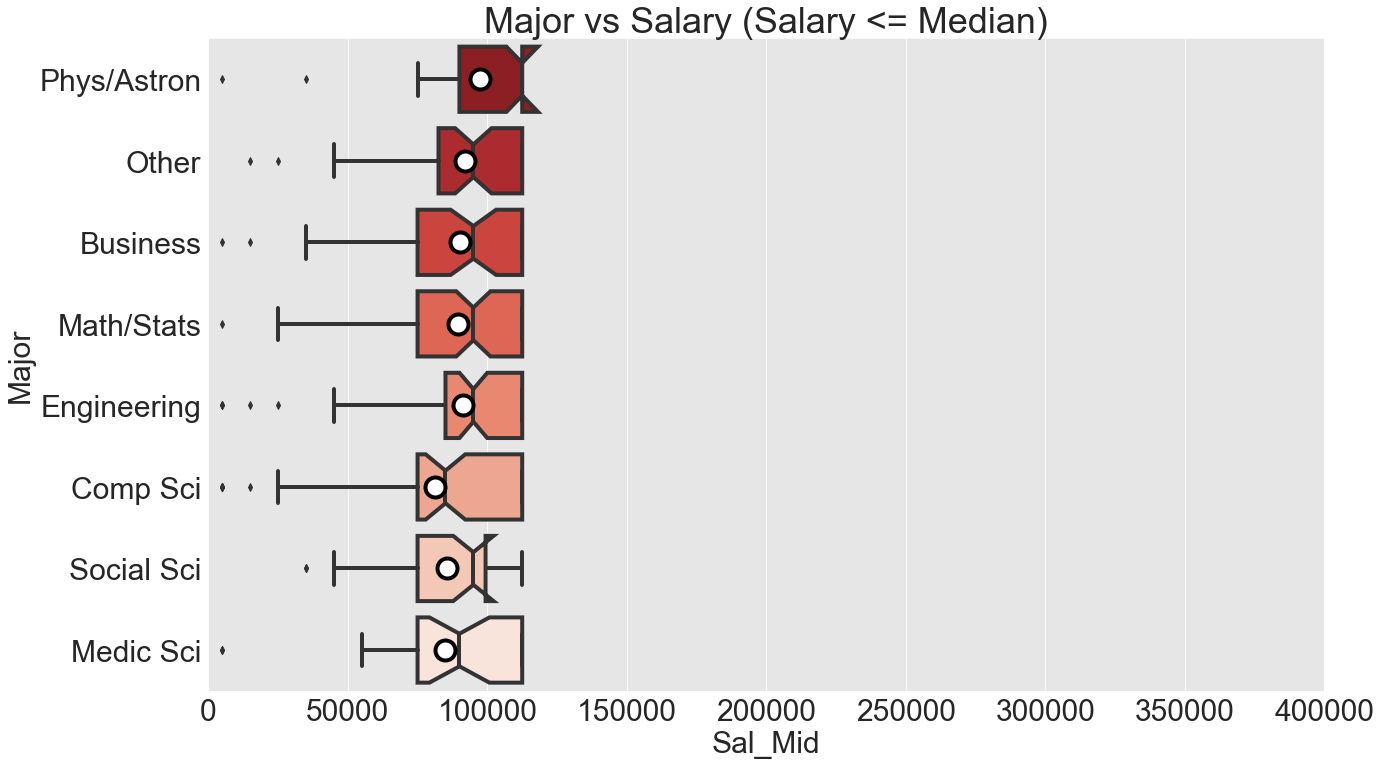

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
   group1      group2     meandiff     lower      upper    reject
-----------------------------------------------------------------
  Business    Comp Sci   -8719.3423 -23055.7991 5617.1146  False 
  Business  Engineering  1237.1795  -12850.6771 15325.0361 False 
  Business   Math/Stats  -775.5017  -14319.9408 12768.9374 False 
  Business   Medic Sci   -5179.4872 -23078.1255 12719.1511 False 
  Business     Other     1730.7692  -13579.7067 17041.2451 False 
  Business  Phys/Astron  7403.8462   -9133.3579 23941.0502 False 
  Business   Social Sci  -4649.7253 -22949.2441 13649.7936 False 
  Comp Sci  Engineering  9956.5217   -3066.1902 22979.2337 False 
  Comp Sci   Math/Stats  7943.8406   -4488.9851 20376.6662 False 
  Comp Sci   Medic Sci   3539.8551  -13533.0643 20612.7744 False 
  Comp Sci     Other     10450.1115  -3886.3454 24786.5683 False 
  Comp Sci  Phys/Astron  16123.1884   483.4173  31762.9595  True 
  Comp Sci

In [19]:
plot(df, "Major", maj_order, "Blues_r")
tukey(df,"Major")
plot(top_df, "Major", maj_order, "Greens_r")
tukey(top_df,"Major")
plot(btm_df, "Major", maj_order, "Reds_r")
tukey(btm_df,"Major")

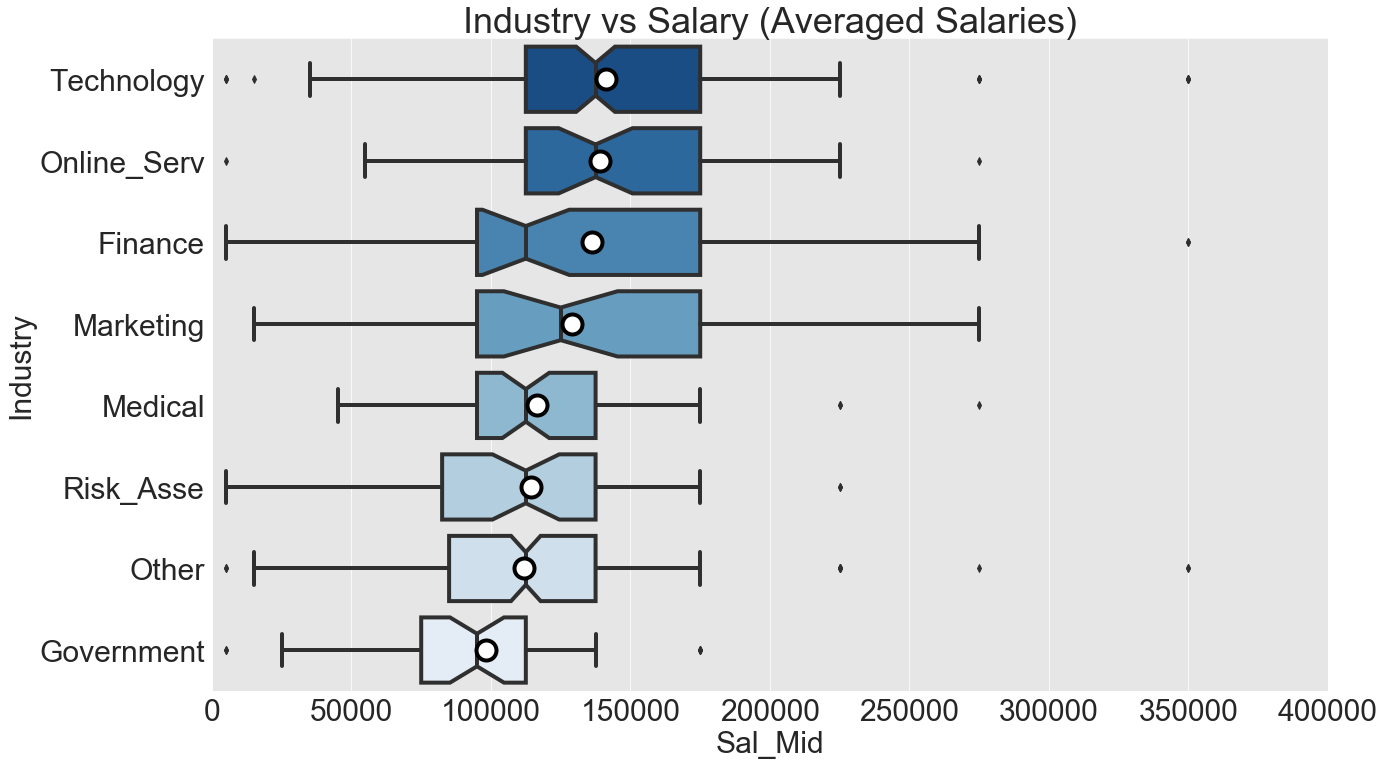

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
   group1      group2     meandiff     lower      upper    reject
-----------------------------------------------------------------
  Finance    Government -38132.0166 -73578.6925 -2685.3408  True 
  Finance    Marketing   -7097.166  -42245.3672 28051.0352 False 
  Finance     Medical   -19760.0733 -50190.7072 10670.5607 False 
  Finance   Online_Serv  2646.8531  -28887.6192 34181.3255 False 
  Finance      Other    -24603.1469 -48648.8674 -557.4263   True 
  Finance    Risk_Asse  -21932.6923 -53956.1004 10090.7157 False 
  Finance    Technology  4986.2775  -19603.3367 29575.8918 False 
 Government  Marketing   31034.8506  -8718.2437 70787.945  False 
 Government   Medical    18371.9434 -17278.2452 54022.132  False 
 Government Online_Serv  40778.8698  4181.9381  77375.8015  True 
 Government    Other     13528.8698 -16853.8414 43911.581  False 
 Government  Risk_Asse   16199.3243  -20819.74  53218.3887 False 
 Governmen

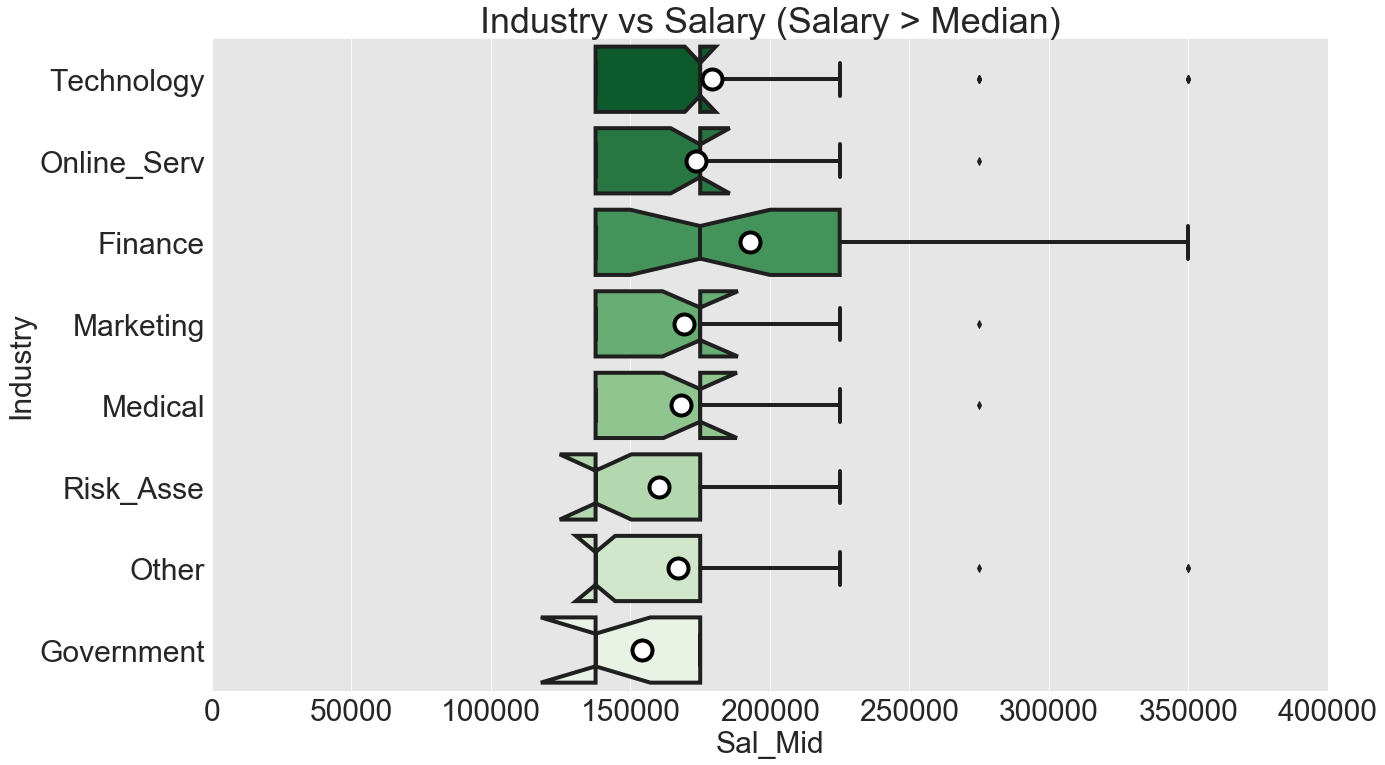

        Multiple Comparison of Means - Tukey HSD,FWER=0.05        
   group1      group2     meandiff     lower       upper    reject
------------------------------------------------------------------
  Finance    Government   -38750.0  -101695.5094 24195.5094 False 
  Finance    Marketing  -23837.7193 -72397.3017  24721.8631 False 
  Finance     Medical   -24791.6667 -72602.2132  23018.8799 False 
  Finance   Online_Serv -19529.5699 -61946.3575  22887.2177 False 
  Finance      Other     -25952.381  -62093.757  10188.9951 False 
  Finance    Risk_Asse   -32797.619 -79920.2082  14324.9701 False 
  Finance    Technology   -13750.0  -47734.6283  20234.6283 False 
 Government  Marketing   14912.2807 -52106.3101  81930.8715 False 
 Government   Medical    13958.3333 -52519.5339  80436.2005 False 
 Government Online_Serv  19220.4301 -43490.3532  81931.2134 False 
 Government    Other     12797.619  -45850.9745  71446.2126 False 
 Government  Risk_Asse    5952.381  -60032.4421  71937.204  Fa

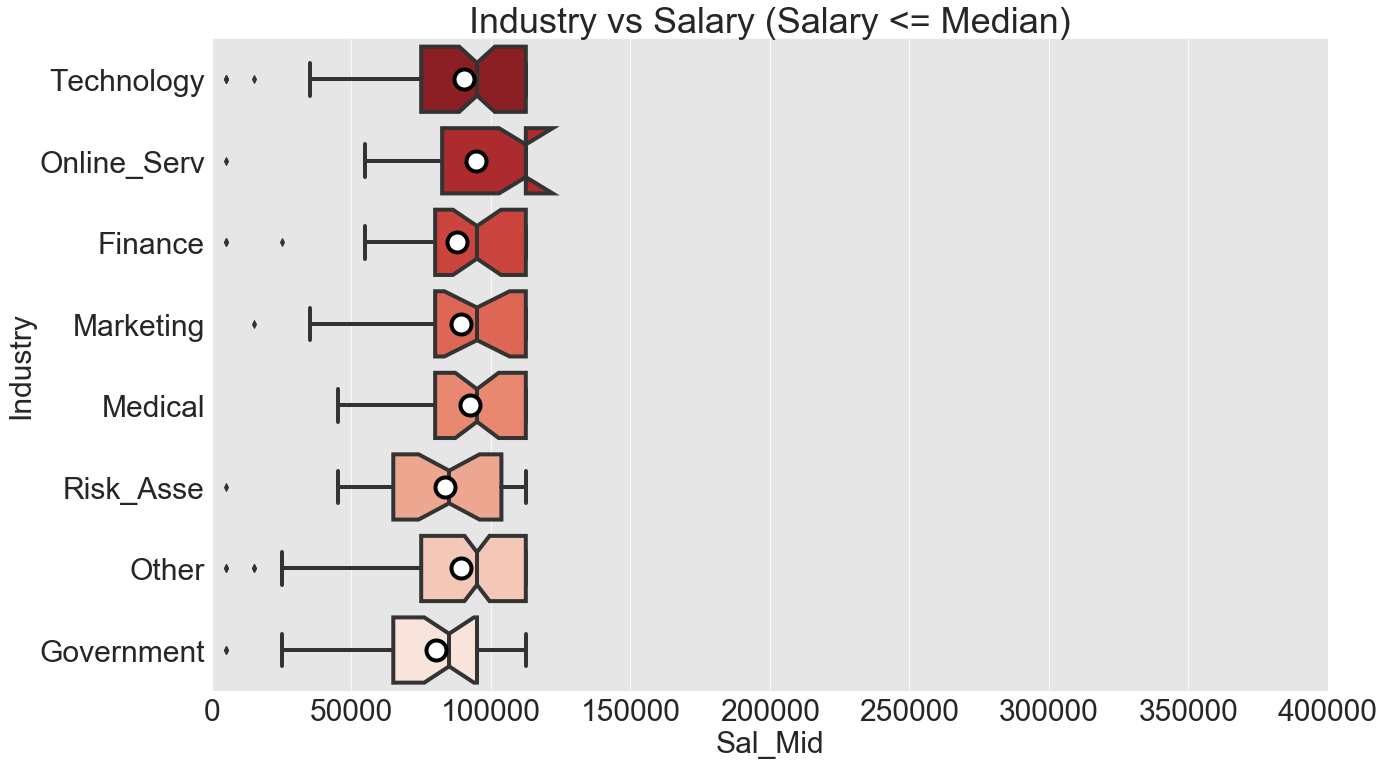

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
   group1      group2     meandiff     lower      upper    reject
-----------------------------------------------------------------
  Finance    Government  -7607.1429 -27537.7174 12323.4316 False 
  Finance    Marketing    1556.391   -20843.641 23956.4229 False 
  Finance     Medical    4772.4252  -13122.9839 22667.8344 False 
  Finance   Online_Serv  6693.4524  -14139.4099 27526.3147 False 
  Finance      Other      1429.402  -13146.9722 16005.7762 False 
  Finance    Risk_Asse   -4398.6175 -23786.0224 14988.7873 False 
  Finance    Technology  2714.2857  -13073.0818 18501.6532 False 
 Government  Marketing   9163.5338  -14200.9232 32527.9909 False 
 Government   Medical    12379.5681  -6709.2268 31468.363  False 
 Government Online_Serv  14300.5952  -7565.922  36167.1124 False 
 Government    Other     9036.5449   -6982.416  25055.5057 False 
 Government  Risk_Asse   3208.5253  -17285.5687 23702.6193 False 
 Governmen

In [20]:
plot(df, "Industry", ind_order, "Blues_r")
tukey(df,"Industry")
plot(top_df, "Industry", ind_order, "Greens_r")
tukey(top_df,"Industry")
plot(btm_df, "Industry", ind_order, "Reds_r")
tukey(btm_df,"Industry")

<div class = "span alert alert-success">
    <h2> Variable Assignment and User-Defined Functions for checking Simpson's paradox in Gender</h2>
    </div>

In [21]:
gen = ['#66b3ff','#ff9999']
gen_top = ['#0d61b5', '#ff6363']
gen_btm = ['#b7d7f7', '#ffd4d4']

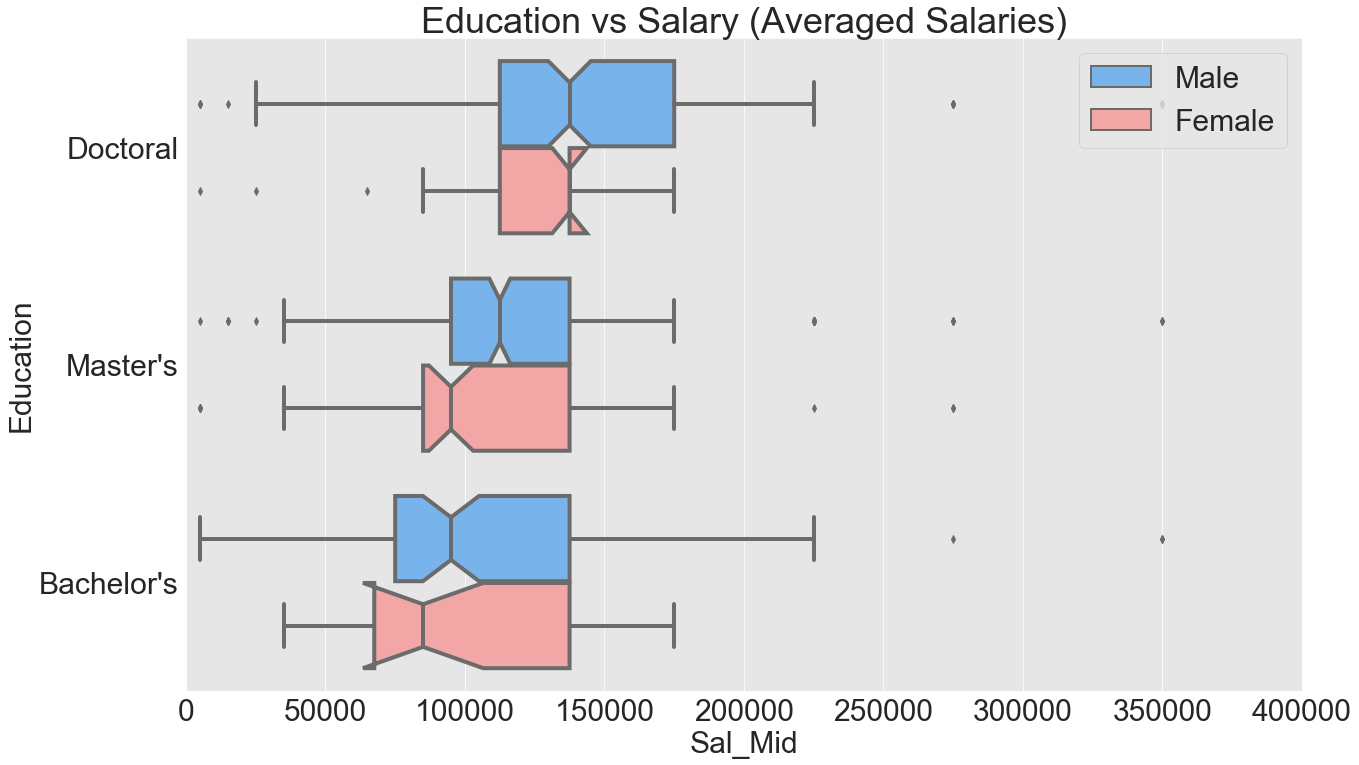

Doctoral's Male vs Female p-value: 0.007
Master's's Male vs Female p-value: 0.000
Bachelor's's Male vs Female p-value: 0.337


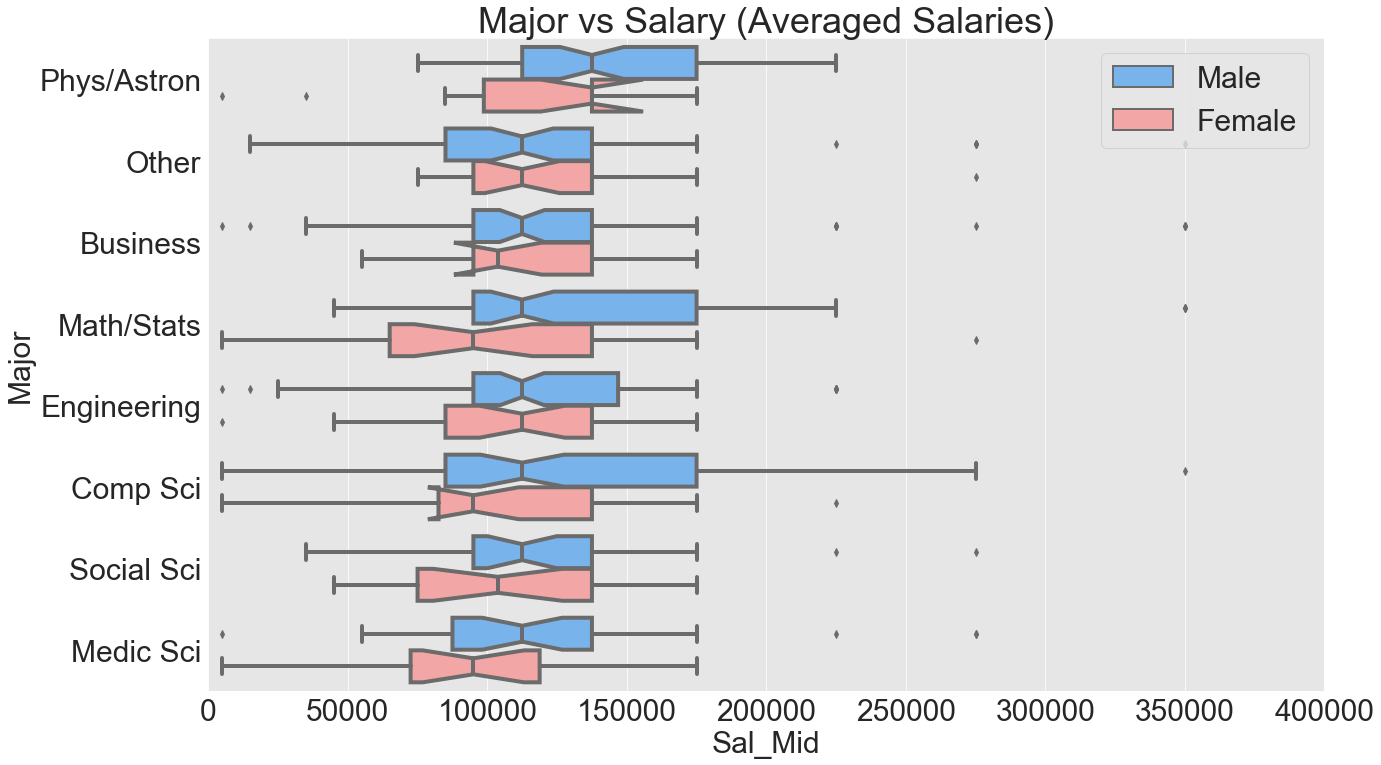

Phys/Astron's Male vs Female p-value: 0.098
Other's Male vs Female p-value: 0.876
Business's Male vs Female p-value: 0.099
Math/Stats's Male vs Female p-value: 0.016
Engineering's Male vs Female p-value: 0.149
Comp Sci's Male vs Female p-value: 0.098
Social Sci's Male vs Female p-value: 0.244
Medic Sci's Male vs Female p-value: 0.067


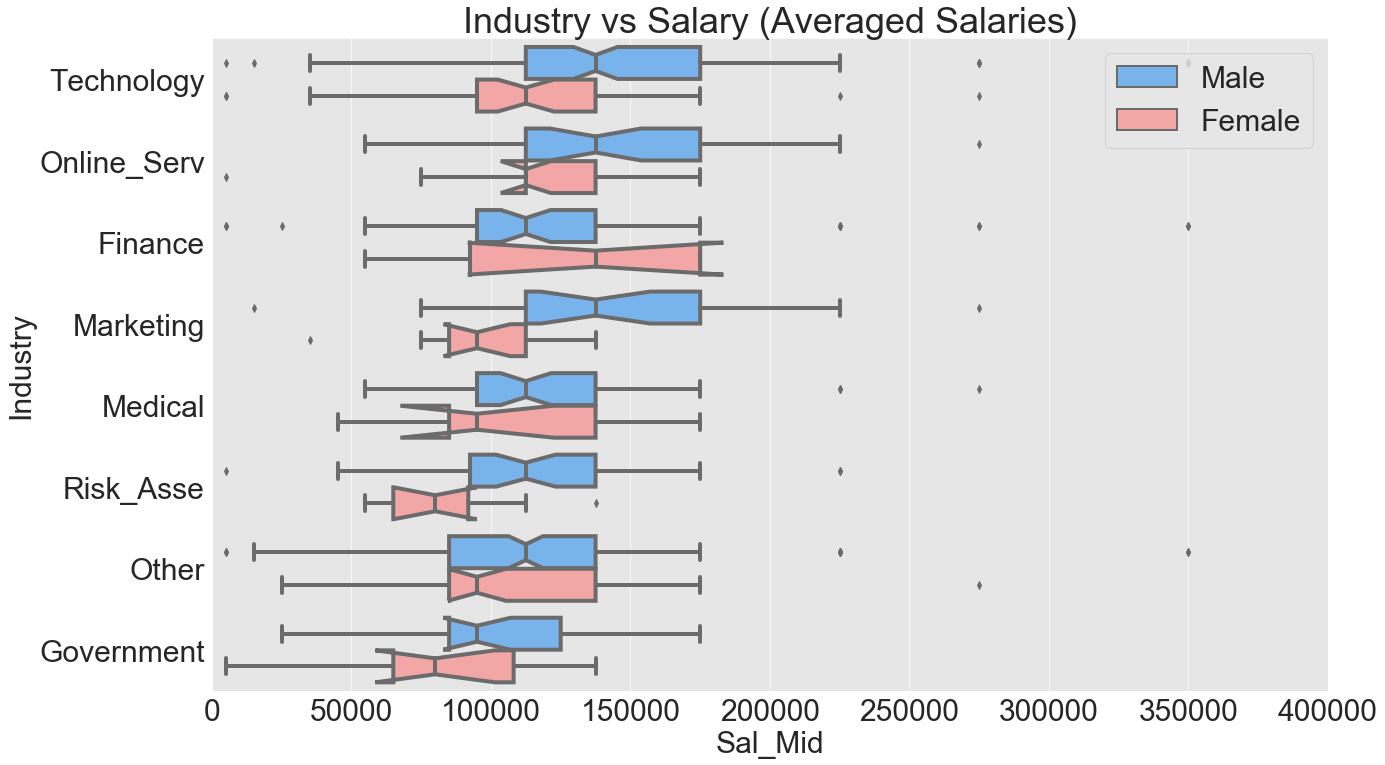

Technology's Male vs Female p-value: 0.006
Online_Serv's Male vs Female p-value: 0.096
Finance's Male vs Female p-value: 0.693
Marketing's Male vs Female p-value: 0.002
Medical's Male vs Female p-value: 0.309
Risk_Asse's Male vs Female p-value: 0.011
Other's Male vs Female p-value: 0.194
Government's Male vs Female p-value: 0.121


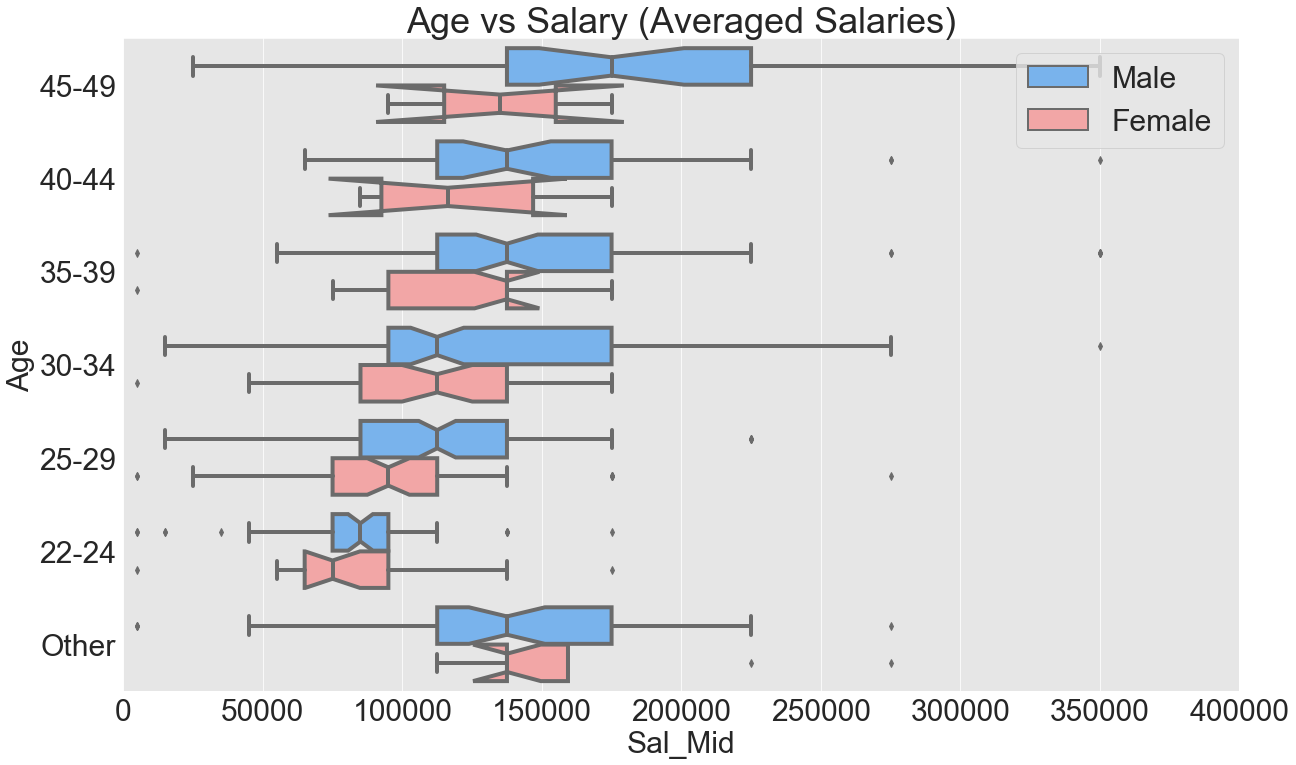

45-49's Male vs Female p-value: 0.436
40-44's Male vs Female p-value: 0.192
35-39's Male vs Female p-value: 0.002
30-34's Male vs Female p-value: 0.016
25-29's Male vs Female p-value: 0.194
22-24's Male vs Female p-value: 0.933
Other's Male vs Female p-value: 0.225


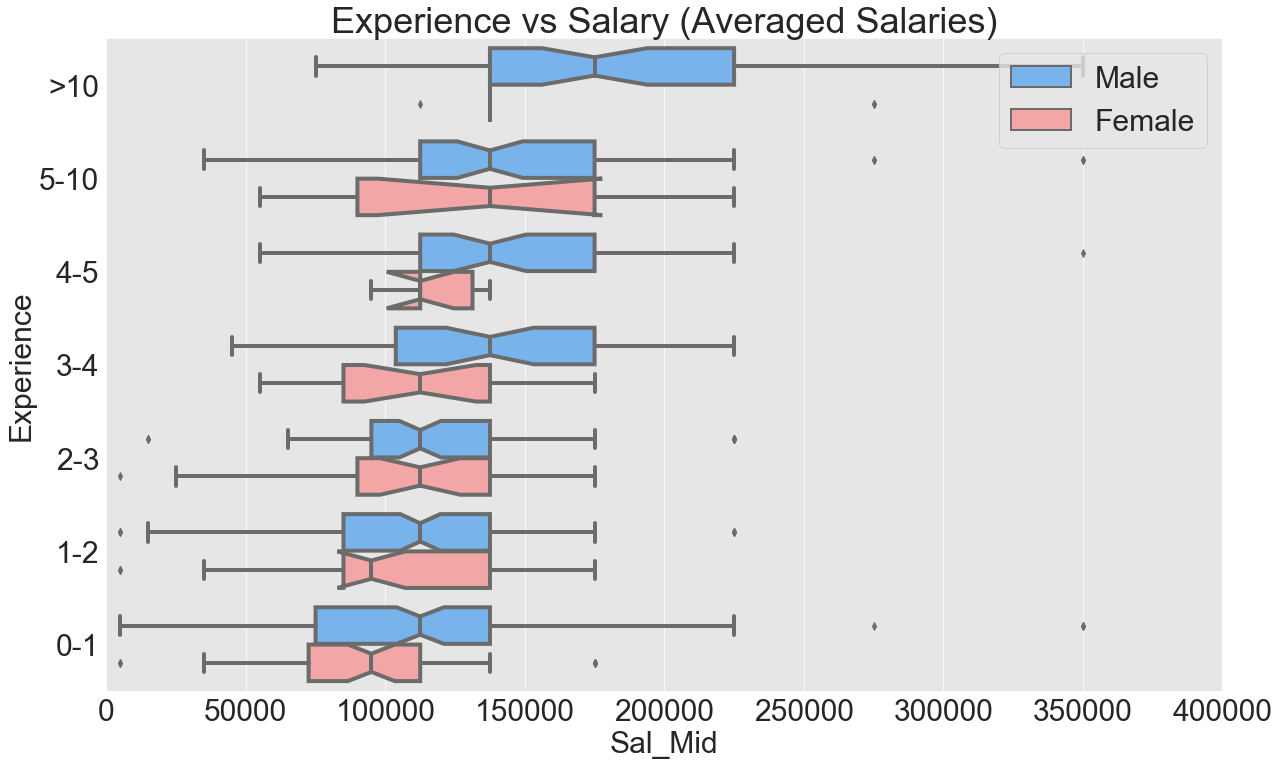

>10's Male vs Female p-value: 0.172
5-10's Male vs Female p-value: 0.266
4-5's Male vs Female p-value: 0.014
3-4's Male vs Female p-value: 0.136
2-3's Male vs Female p-value: 0.099
1-2's Male vs Female p-value: 0.509
0-1's Male vs Female p-value: 0.122


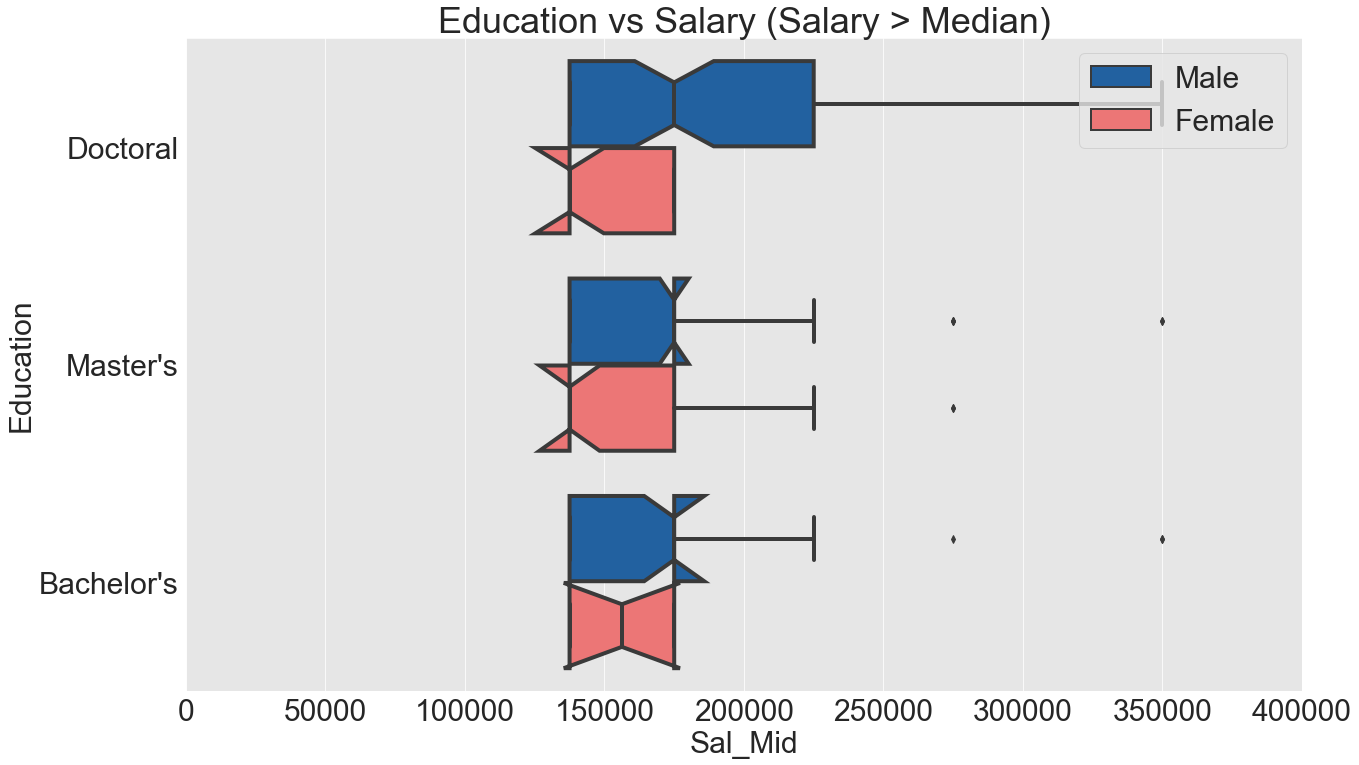

Doctoral's Male vs Female p-value: 0.000
Master's's Male vs Female p-value: 0.084
Bachelor's's Male vs Female p-value: 0.163


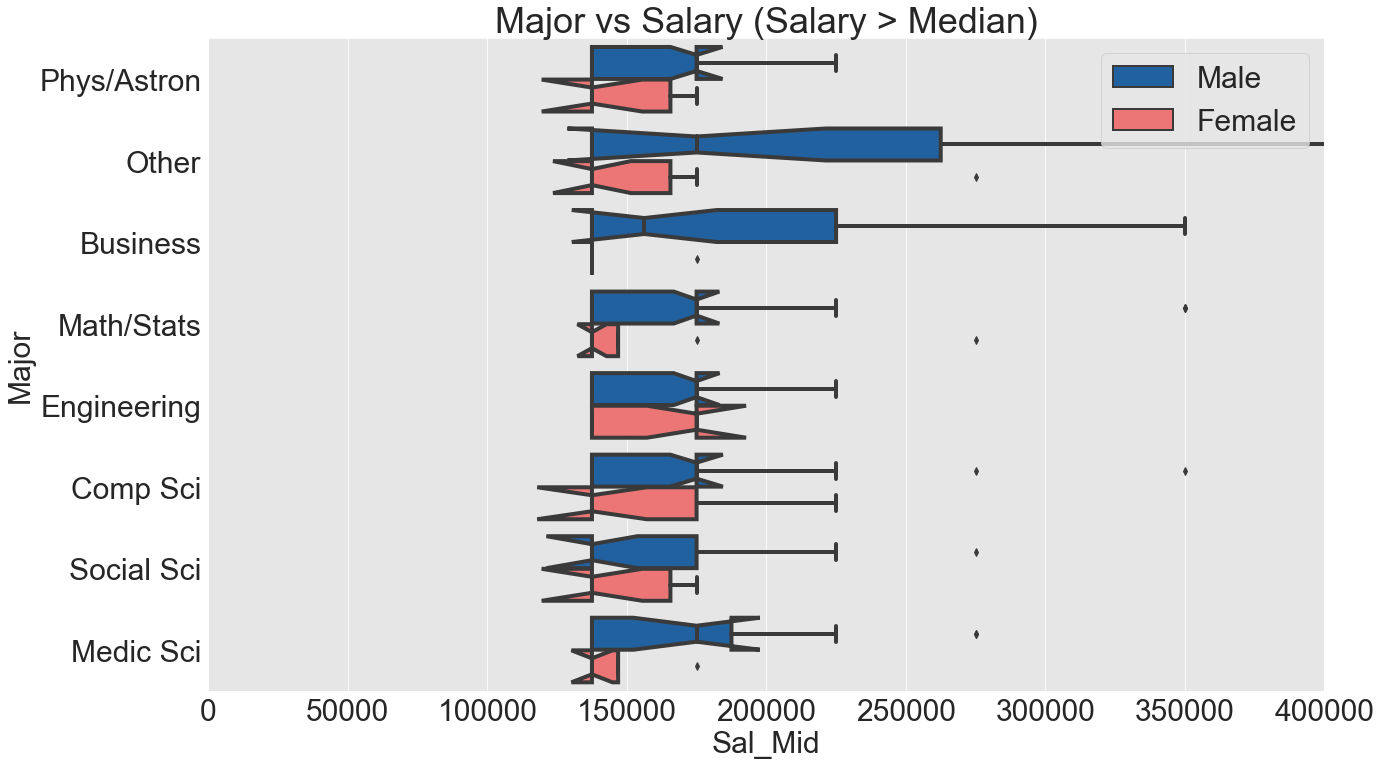

Phys/Astron's Male vs Female p-value: 0.024
Other's Male vs Female p-value: 0.076
Business's Male vs Female p-value: 0.005
Math/Stats's Male vs Female p-value: 0.333
Engineering's Male vs Female p-value: 0.469
Comp Sci's Male vs Female p-value: 0.118
Social Sci's Male vs Female p-value: 0.359
Medic Sci's Male vs Female p-value: 0.079


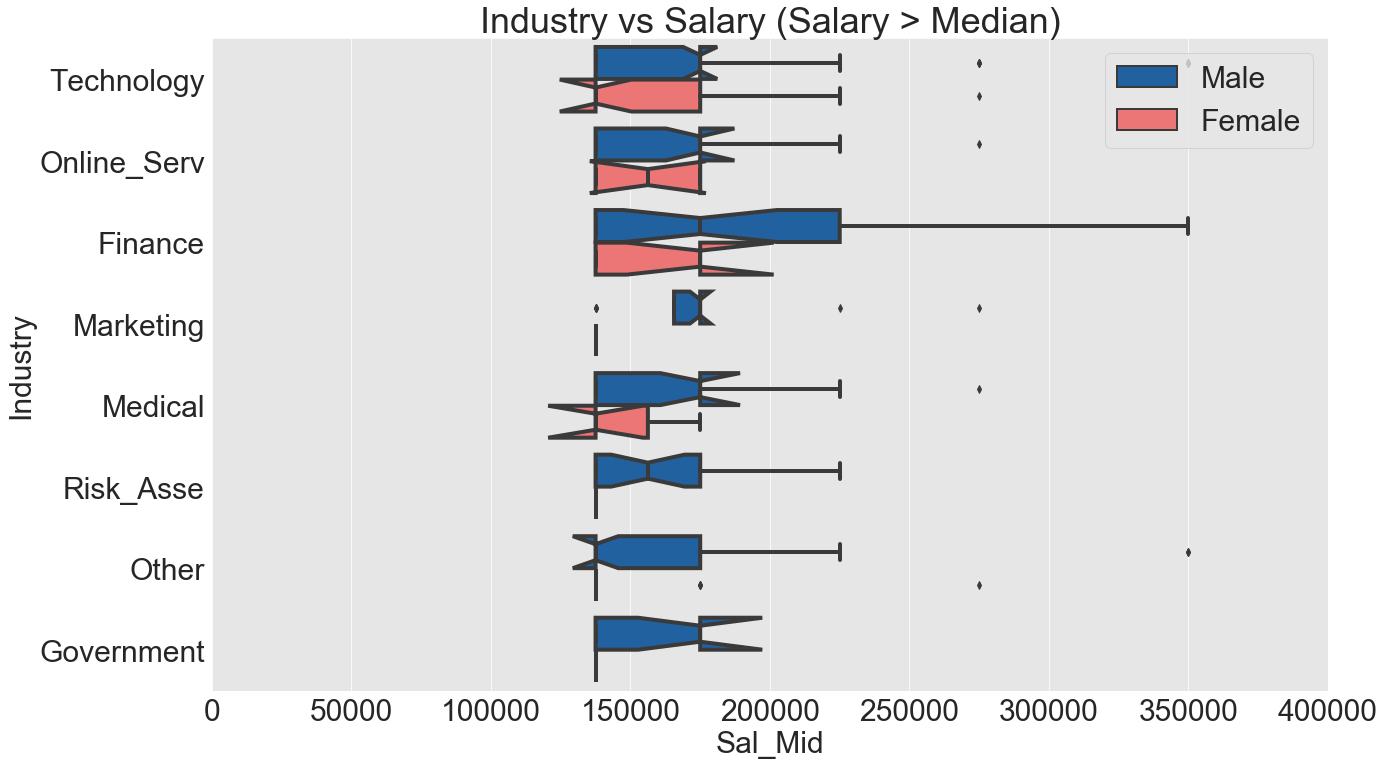

Technology's Male vs Female p-value: 0.025
Online_Serv's Male vs Female p-value: 0.160
Finance's Male vs Female p-value: 0.048
Marketing's Male vs Female p-value: 0.001
Medical's Male vs Female p-value: 0.235
Risk_Asse's Male vs Female p-value: nan
Other's Male vs Female p-value: 0.077
Government's Male vs Female p-value: 0.030


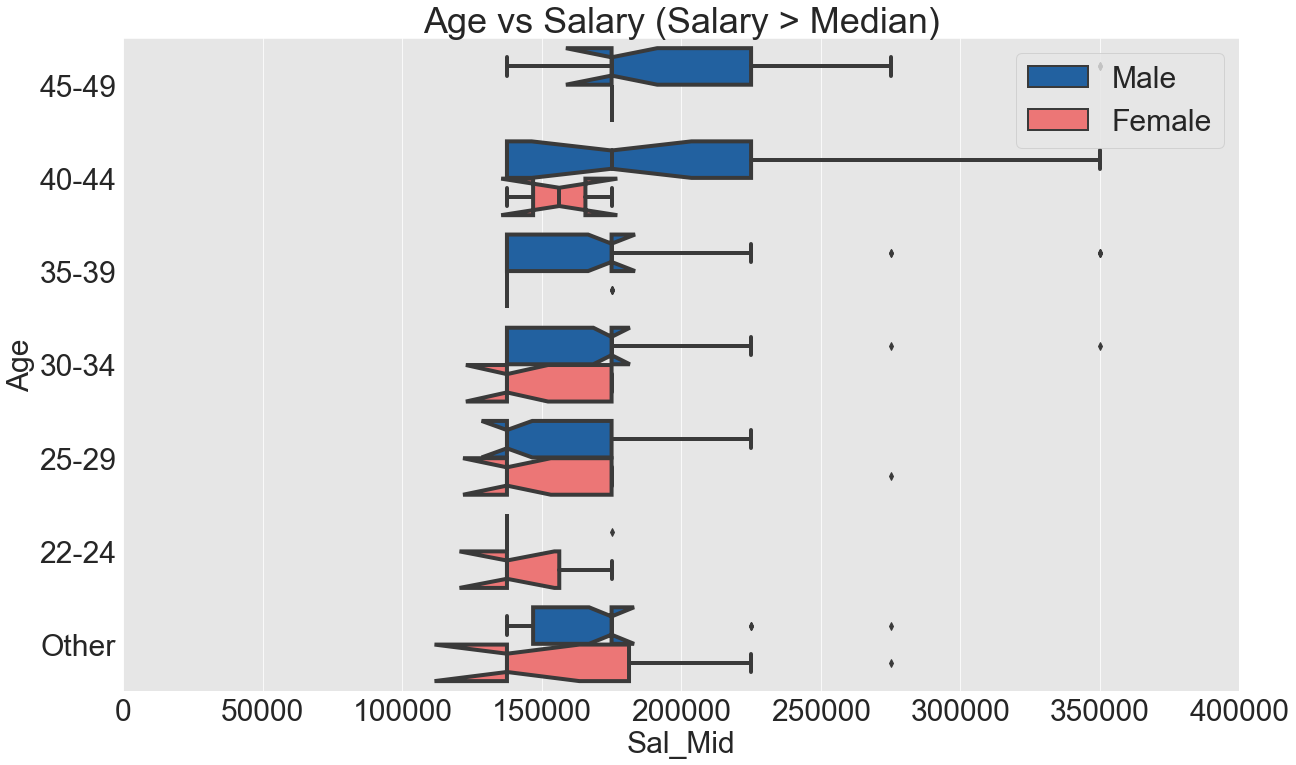

45-49's Male vs Female p-value: nan
40-44's Male vs Female p-value: 0.216
35-39's Male vs Female p-value: 0.000
30-34's Male vs Female p-value: 0.007
25-29's Male vs Female p-value: 0.957
22-24's Male vs Female p-value: 0.751
Other's Male vs Female p-value: 0.873


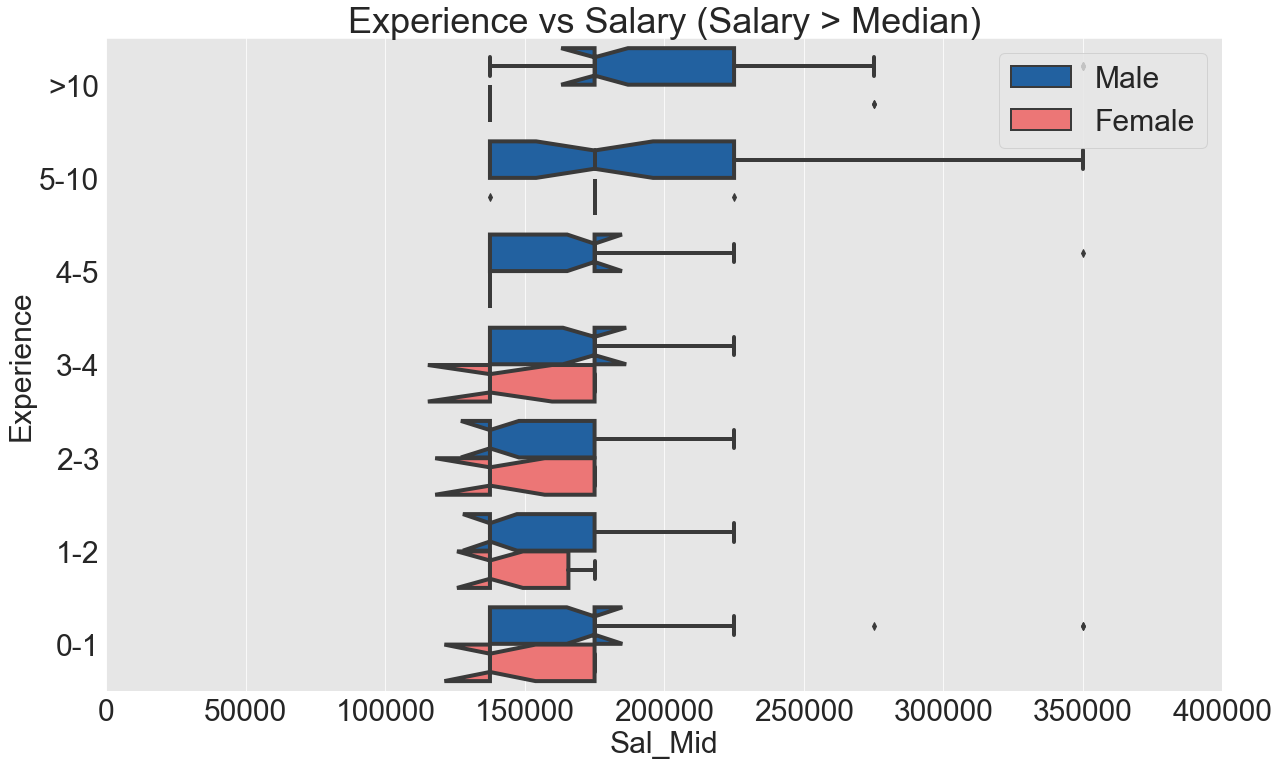

>10's Male vs Female p-value: 0.053
5-10's Male vs Female p-value: 0.366
4-5's Male vs Female p-value: 0.000
3-4's Male vs Female p-value: 0.297
2-3's Male vs Female p-value: 0.071
1-2's Male vs Female p-value: 0.147
0-1's Male vs Female p-value: 0.017


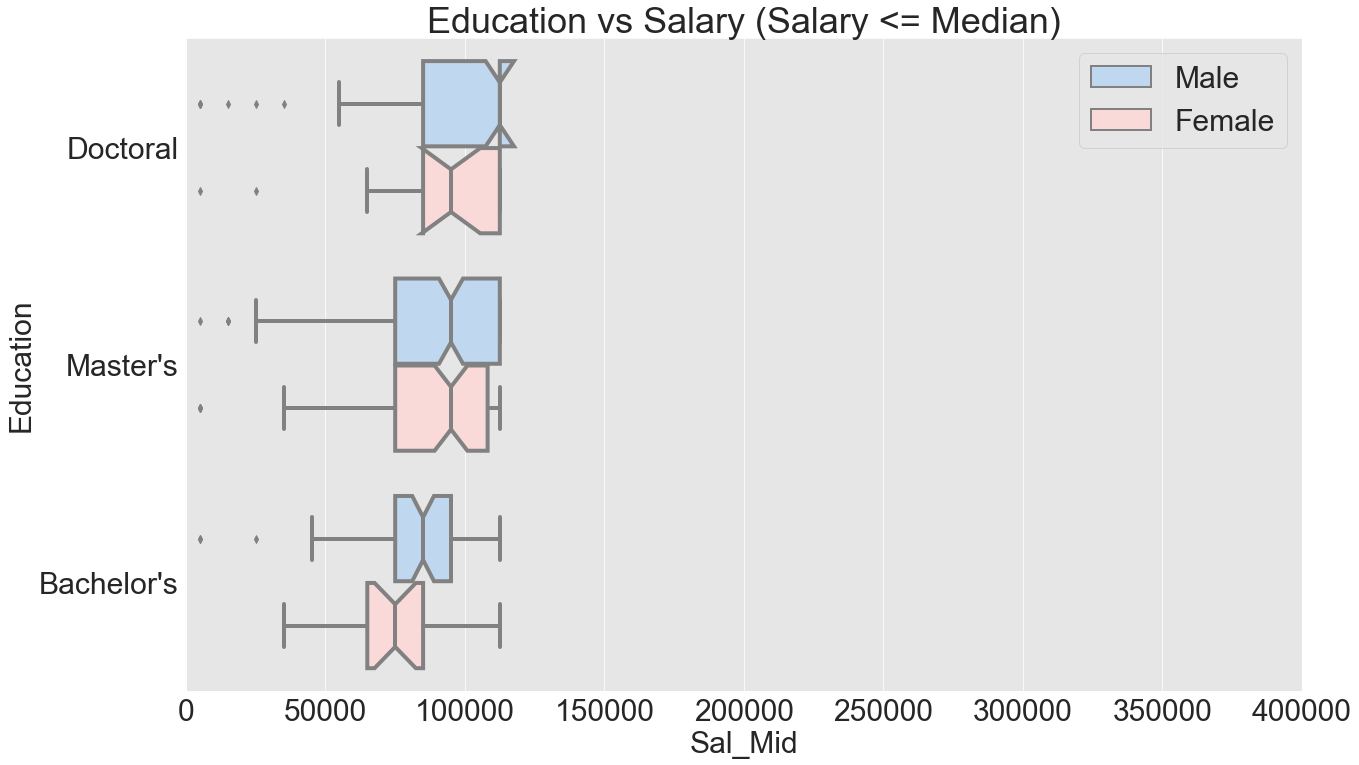

Doctoral's Male vs Female p-value: 0.716
Master's's Male vs Female p-value: 0.059
Bachelor's's Male vs Female p-value: 0.374


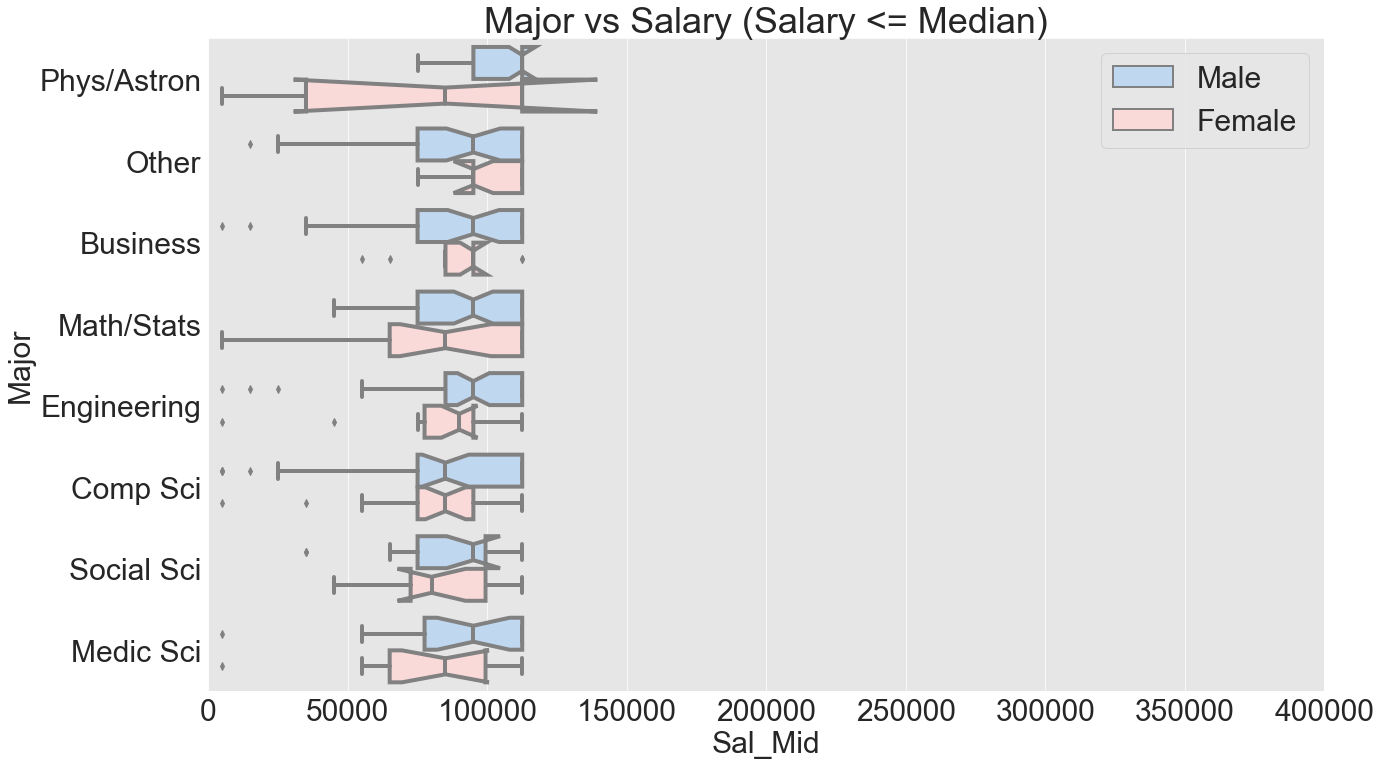

Phys/Astron's Male vs Female p-value: 0.218
Other's Male vs Female p-value: 0.021
Business's Male vs Female p-value: 0.986
Math/Stats's Male vs Female p-value: 0.089
Engineering's Male vs Female p-value: 0.289
Comp Sci's Male vs Female p-value: 0.991
Social Sci's Male vs Female p-value: 0.714
Medic Sci's Male vs Female p-value: 0.482


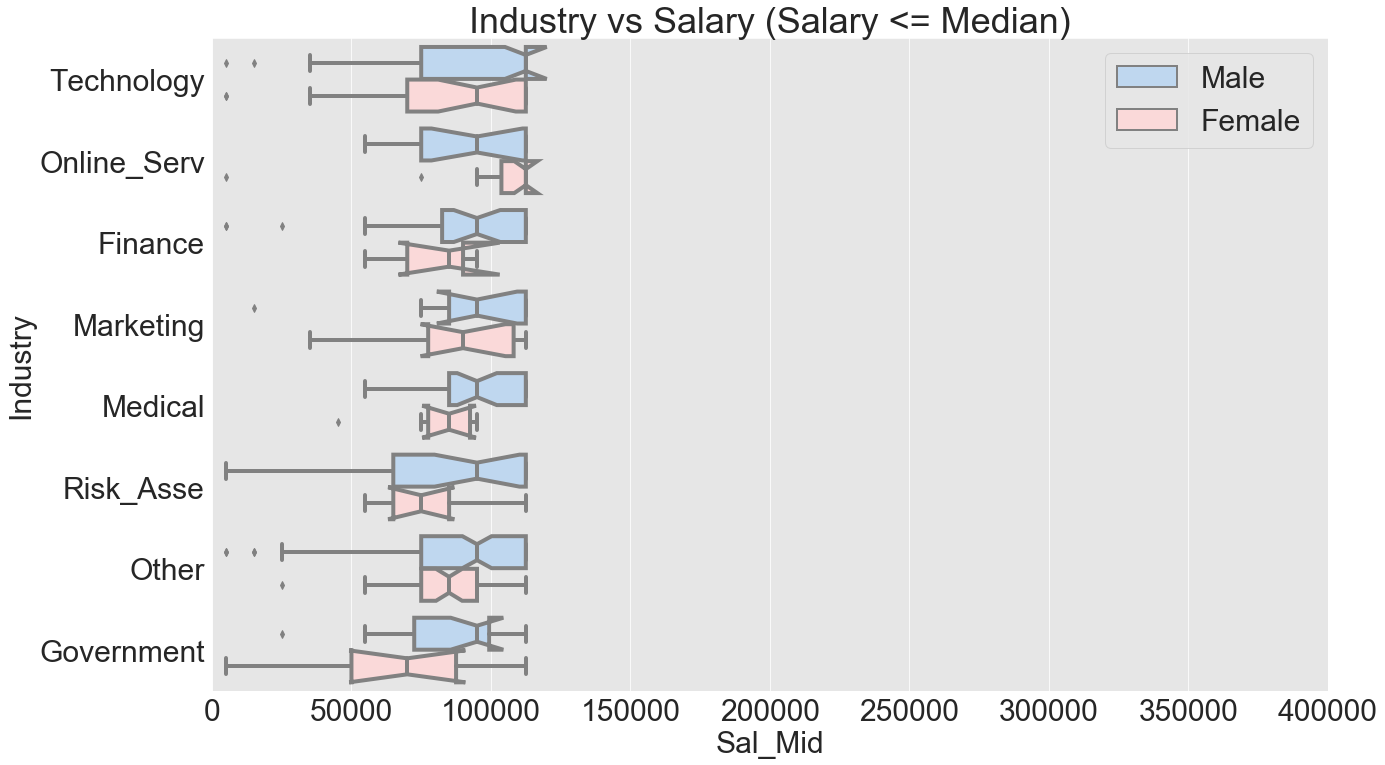

Technology's Male vs Female p-value: 0.266
Online_Serv's Male vs Female p-value: 0.606
Finance's Male vs Female p-value: 0.491
Marketing's Male vs Female p-value: 0.861
Medical's Male vs Female p-value: 0.120
Risk_Asse's Male vs Female p-value: 0.414
Other's Male vs Female p-value: 0.500
Government's Male vs Female p-value: 0.149


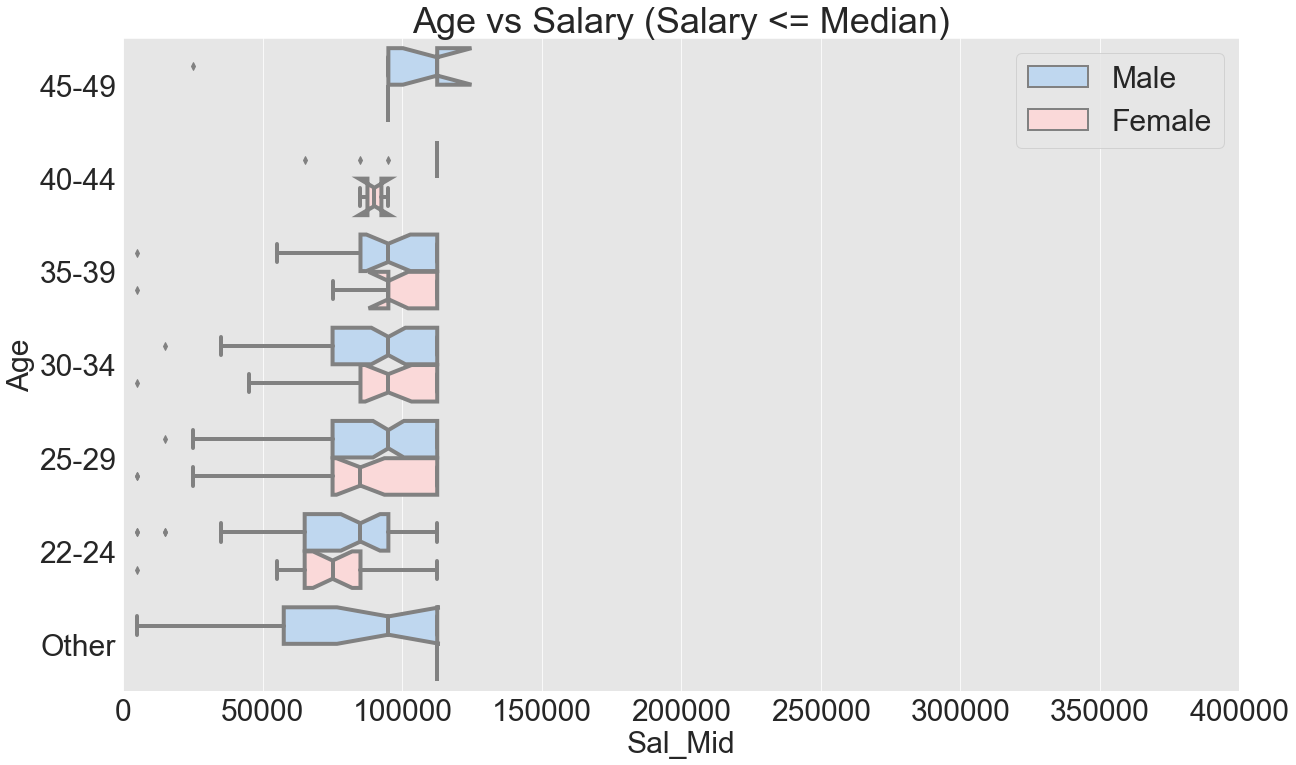

45-49's Male vs Female p-value: nan
40-44's Male vs Female p-value: 0.103
35-39's Male vs Female p-value: 0.895
30-34's Male vs Female p-value: 0.342
25-29's Male vs Female p-value: 0.107
22-24's Male vs Female p-value: 0.715
Other's Male vs Female p-value: nan


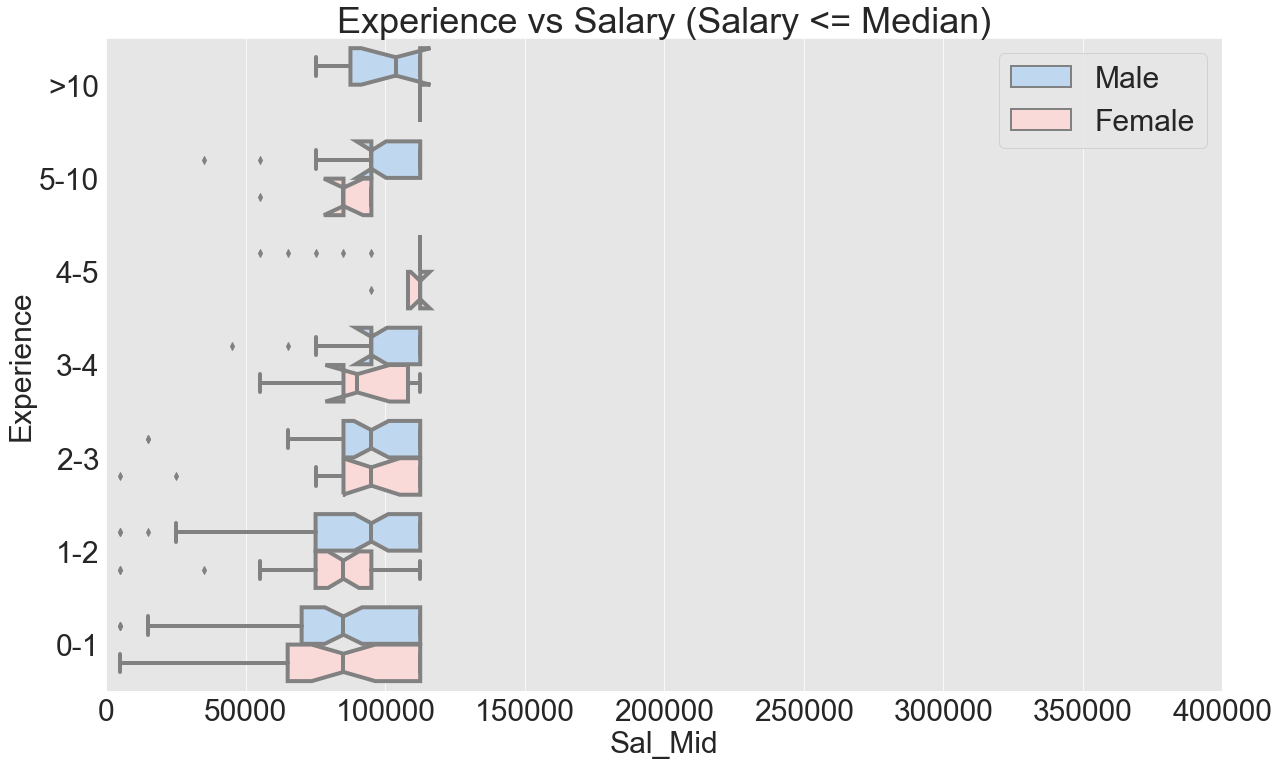

>10's Male vs Female p-value: nan
5-10's Male vs Female p-value: 0.112
4-5's Male vs Female p-value: 0.457
3-4's Male vs Female p-value: 0.297
2-3's Male vs Female p-value: 0.487
1-2's Male vs Female p-value: 0.395
0-1's Male vs Female p-value: 0.583


In [22]:
def gen_t_test(df, feature, subfeature):
    # example: gen_t_test(df,"Education","Bachelor's")
    m_df = df[df["Gender"] == "Male"]
    f_df = df[df["Gender"] == "Female"]
    t,p = stats.ttest_ind(m_df.Sal_Mid[m_df[feature] == subfeature],
                          f_df.Sal_Mid[f_df[feature] == subfeature], equal_var = False)
    print(subfeature + "'s", "Male vs Female p-value:", "{:.3f}".format(p))
    
    #Gen stands for Gender; for exploring if Simpson's Paradox is occurring

def gen_plot(df, column, order, palette):
    if palette == gen:
        title = "(Averaged Salaries)"
        
    if palette == gen_top:
        title = "(Salary > Median)"
        
    if palette == gen_btm:
        title = "(Salary <= Median)"  
        
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize = (20, 12))
    mpl.rcParams['font.size'] = 30

    sns.boxplot(x = df["Sal_Mid"], y = df[column], notch=True,
                hue = df["Gender"], hue_order = ["Male","Female"],
                linewidth = 4, palette = palette, order = order)
    #sns.swarmplot(x = df["Sal_Mid"], y = df[column],
    #              hue = df["Gender"], hue_order = ["Male","Female"],
    #              color = "white",order = order)

    plt.xlim(0,400000)
    plt.title(column + " vs Salary " + title)
    plt.legend(loc="upper right")
    return plt.show()

def gen_plot_t_test(df, feature, subfeatures, palette):
    gen_plot(df, feature, subfeatures, palette)
    for subfeature in subfeatures:
        gen_t_test(df, feature, subfeature)

def gen_check(df, feature, palette):
    if feature == "Experience":
        subfeatures = exp_order
        gen_plot_t_test(df, feature, subfeatures, palette)
       
    if feature == "Major":
        subfeatures = maj_order
        gen_plot_t_test(df, feature, subfeatures, palette)
            
    if feature == "Industry":
        subfeatures = ind_order
        gen_plot_t_test(df, feature, subfeatures, palette)
            
    if feature == "Education":
        subfeatures = edu_order
        gen_plot_t_test(df, feature, subfeatures, palette)
           
    if feature == "Age":
        subfeatures = age_order
        gen_plot_t_test(df, feature, subfeatures, palette)
    
for feature in df.columns:
    gen_check(df, feature, gen)
    
for feature in top_df.columns:
    gen_check(top_df, feature, gen_top)
    
for feature in btm_df.columns:
    gen_check(btm_df, feature, gen_btm)